# Video Manager

In [1]:
from PIL import Image
import numpy as np
import torch
from pathlib import Path
import cv2
import pandas as pd
from ast import literal_eval
from loguru import logger
# from videoPredictor import VideoManager
from matplotlib import pyplot as plt
from datetime import datetime

from inference import PerShelfChillerPredictor
from shelfSettings import STORE_MAPPER
from frameSelector.classificationInference import VideoClassification, ClassificationPredictor, StatusErrors, VideoDecodeError, UnableToOpenFile
from shelfPredictor import ShelfPredictor, PredictedShelf, PredictedChiller
from tqdm.auto import tqdm
from videoSubImageExtractor import get_chiller_predictor
from analyzeVideos import VideoManager

/home/akshay/.virtualenvs/detectron2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-07-19 22:03:01.136 | INFO     | shelfSettings:__init__:115 - Initializing StoreManager with raise_exception: True
2024-07-19 22:03:01.141 | INFO     | shelfSettings:__init__:120 - Loaded store: Demo Unit Pune: 08B61F99AF90: DemoUnit
2024-07-19 22:03:01.142 | INFO     | shelfSettings:__init__:120 - Loaded store: 9 Caser - Frigo: 08F9E0F662D8: Madhuban Rasoi
2024-07-19 22:03:01.142 | INFO     | shelfSettings:__init__:120 - Loaded store: 14 Caser-Western: 08B61F99B440: Rajal Dryfruits
2024-07-19 22:03:01.143 | INFO     | shelfSettings:__init__:120 - Loaded store: 14 Caser-Western2: C82E18224378: Rajal Dryfruits2
2024-07-19 22:03:01.143 | INFO     | shelfSettings:__init__:120 - Loaded store: 9 Caser-Western: 08F9E0ECCC

[07/19 22:03:01 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ../models/shelf_model/model/shelf_model.pth ...


2024-07-19 22:03:01.880 | INFO     | segmentationInference:__init__:238 - Loading model from: ../models/bottle_model/model/bottle_model.pth to cuda


[07/19 22:03:02 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ../models/bottle_model/model/bottle_model.pth ...


2024-07-19 22:03:02.698 | INFO     | perShelfPredictor:__init__:27 - Loaded model: ../models/PETClassification.pth with categories: ['7Up', 'AquafinaWater', 'BisleriWater', 'Charged', 'Coke', 'DukeSoda', 'Fanta', 'KinleySoda', 'KinleyWater', 'Limca', 'Maaza', 'MinuteMaid', 'Mirinda', 'Pepsi', 'RimZim', 'Slice', 'Sprite', 'Sting', 'SunriseWater', 'ThumsUp']
2024-07-19 22:03:02.936 | INFO     | perShelfPredictor:__init__:27 - Loaded model: ../models/CanClassification.pth with categories: ['7Up', 'Coke', 'CokeZero', 'Mirinda', 'Monster', 'Pepsi', 'PepsiZero', 'Predator', 'RedBull', 'Sprite', 'ThumsUp']
2024-07-19 22:03:03.169 | INFO     | perShelfPredictor:__init__:27 - Loaded model: ../models/RGBClassification.pth with categories: ['Coke', 'Fanta', 'Limca', 'Sprite', 'ThumsUp']
2024-07-19 22:03:03.403 | INFO     | perShelfPredictor:__init__:27 - Loaded model: ../models/TetraClassification.pth with categories: ['AmulLassi', 'AmulMasti', 'Frooti', 'Maaza', 'RealMango']
2024-07-19 22:03:03.

In [2]:
%%time
parquet_frame_path = Path("/media/akshay/datasets/coke/siteData/videoAnalysis.parquet")
frame = pd.read_parquet(parquet_frame_path)

CPU times: user 113 ms, sys: 109 ms, total: 221 ms
Wall time: 167 ms


In [4]:
%%time
v = VideoManager()

2024-07-19 22:15:28.529 | INFO     | analyzeVideos:_get_video_analysis_frame:96 - Loading video analysis frame: /media/akshay/datasets/coke/siteData/videoAnalysis.parquet records: 85900 last modified: 2024-07-19 21:36:32.578928
2024-07-19 22:15:52.808 | INFO     | analyzeVideos:load_frame:44 - Loading video analysis frame: /media/akshay/datasets/coke/siteData/videoAnalysis.csv records: 85900 last modified: 2024-07-19 21:36:32.578928


CPU times: user 24.3 s, sys: 243 ms, total: 24.6 s
Wall time: 24.5 s


In [5]:
%%time
frame["video_status"] = frame.category.apply(v._get_error_status)
frame["category"] = frame.category.apply(v._fix_category_errors)
frame["confidence"] = frame.confidence.apply(v._fix_category_errors)

CPU times: user 48.6 ms, sys: 29 µs, total: 48.6 ms
Wall time: 48.9 ms


In [6]:
%%time
frame["category"] = frame["category"].apply(lambda x: literal_eval(str(x)))
frame["confidence"] = frame["confidence"].apply(lambda x: literal_eval(str(x)))

CPU times: user 4.03 s, sys: 87.2 ms, total: 4.11 s
Wall time: 4.13 s


In [7]:
%%time
frame["video_status"] = frame.category.apply(v._get_video_status)
frame['store_name'] = frame.file.apply(lambda x: STORE_MAPPER.get_shelf_settings(x).name)

CPU times: user 5.55 s, sys: 7.65 ms, total: 5.55 s
Wall time: 5.57 s


In [12]:
%%time
frame['store_asset_name'] = frame.file.apply(lambda x: STORE_MAPPER.get_shelf_settings(x).asset_name)
frame['mac_id'] = frame.file.apply(lambda x: STORE_MAPPER.get_shelf_settings(x).mac_id)
frame['date'] = frame.file.apply(v._get_timestamp_from_path)

CPU times: user 14.1 s, sys: 10.9 ms, total: 14.1 s
Wall time: 14.1 s


In [ ]:
%%time
frame.set_index('date', inplace=True)

In [4]:
%%time
parquet_frame_path = Path("/media/akshay/datasets/coke/siteData/videoAnalysis.csv")
frame = pd.read_csv(parquet_frame_path)

CPU times: user 327 ms, sys: 49.1 ms, total: 376 ms
Wall time: 374 ms


In [33]:
%%time
video_manager = VideoManager()

2024-07-18 19:04:48.797 | INFO     | __main__:__init__:14 - Loading video analysis frame: /media/akshay/datasets/coke/siteData/videoAnalysis.csv records: 80191


CPU times: user 21.3 s, sys: 148 ms, total: 21.5 s
Wall time: 21.4 s


In [34]:
top3 = video_manager.get_top3_frame(from_date='2024-07-16', to_date='2024-07-18')

2024-07-18 19:05:14.109 | INFO     | __main__:get_top3_frame:87 - Filtering from: 2024-07-16 to: 2024-07-18. top3 size before: 4198 top3 size after: 628


In [35]:
grouped = top3.groupby('store_asset_name')
keys = grouped.groups.keys()
top3[top3.index > '2024-07-01']

file  \
date                                                                     
2024-07-16 05:03:21  /media/akshay/datasets/coke/siteData/34987AB61...   
2024-07-16 05:16:29  /media/akshay/datasets/coke/siteData/34987AB61...   
2024-07-16 06:20:01  /media/akshay/datasets/coke/siteData/840D8E1AA...   
2024-07-16 07:07:46  /media/akshay/datasets/coke/siteData/08B61F99B...   
2024-07-16 07:09:27  /media/akshay/datasets/coke/siteData/08B61F99B...   
...                                                                ...   
2024-07-17 22:41:41  /media/akshay/datasets/coke/siteData/34987AB61...   
2024-07-17 22:43:18  /media/akshay/datasets/coke/siteData/FCE8C0CE2...   
2024-07-17 22:49:50  /media/akshay/datasets/coke/siteData/34987AB61...   
2024-07-17 22:51:18  /media/akshay/datasets/coke/siteData/34987AB61...   
2024-07-17 23:14:18  /media/akshay/datasets/coke/siteData/34987AB61...   

                                                              category  \
date                                                                     
2024-07-16 05:03:21  [tooObstructed, tooObstructed, tooObstructed, ...   
2024-07-16 05:16:29  [top3Clear, top3Clear, top3Clear, tooObstructe...   
2024-07-16 06:20:01  [top3Clear, top3Clear, tooObstructed, tooObstr...   
2024-07-16 07:07:46  [closedDoor, notOpenEnough, notOpenEnough, not...   
2024-07-16 07:09:27  [tooObstructed, top3Clear, top3Clear, top3Clea...   
...                                                                ...   
2024-07-17 22:41:41  [notOpenEnough, notOpenEnough, notOpenEnough, ...   
2024-07-17 22:43:18  [top3Clear, tooObstructed, top3Clear, tooObstr...   
2024-07-17 22:49:50  [closedDoor, closedDoor, closedDoor, closedDoo...   
2024-07-17 22:51:18  [closedDoor, closedDoor, closedDoor, notOpenEn...   
2024-07-17 23:14:18  [closedDoor, closedDoor, closedDoor, closedDoo...   

                                                            confidence  \
date                                                                     
2024-07-16 05:03:21  [0.9867843985557556, 0.9916292428970337, 0.996...   
2024-07-16 05:16:29  [0.5520766377449036, 0.5659320950508118, 0.623...   
2024-07-16 06:20:01  [0.6397307515144348, 0.6231237649917603, 0.879...   
2024-07-16 07:07:46  [0.49865400791168213, 0.7235757112503052, 0.99...   
2024-07-16 07:09:27  [0.9434279203414917, 0.7547340393066406, 0.786...   
...                                                                ...   
2024-07-17 22:41:41  [0.9262614250183105, 0.9196605086326599, 0.912...   
2024-07-17 22:43:18  [0.48939675092697144, 0.49925166368484497, 0.4...   
2024-07-17 22:49:50  [0.9998379945755005, 0.9998916387557983, 0.999...   
2024-07-17 22:51:18  [0.9999605417251587, 0.9998912811279297, 0.975...   
2024-07-17 23:14:18  [0.999967098236084, 0.999966025352478, 0.99999...   

                    video_status   store_name store_asset_name        mac_id  
date                                                                          
2024-07-16 05:03:21    top3Clear  Jipmer Café               P1  34987AB61888  
2024-07-16 05:16:29    top3Clear  Jipmer Café               P1  34987AB61888  
2024-07-16 06:20:01    top3Clear         PG03             PG03  840D8E1AAE54  
2024-07-16 07:07:46    top3Clear         PG02             PG02  08B61F99BC18  
2024-07-16 07:09:27    top3Clear         PG02             PG02  08B61F99BC18  
...                          ...          ...              ...           ...  
2024-07-17 22:41:41    top3Clear  Jipmer Café               P1  34987AB61888  
2024-07-17 22:43:18    top3Clear         VG06             VG06  FCE8C0CE262C  
2024-07-17 22:49:50    top3Clear  Jipmer Café               P1  34987AB61888  
2024-07-17 22:51:18    top3Clear  Jipmer Café               P1  34987AB61888  
2024-07-17 23:14:18    top3Clear  Jipmer Café               P1  34987AB61888  

[628 rows x 7 columns]

In [37]:
for k in keys:
    group = grouped.get_group(k)
    if len(group) > 2:
        g = group.sample(2)
        print(f"{k:4}: {len(g)}")
    else:
        print(f"{k}: {len(group)}")

P1  : 2
P6: 1
P8  : 2
PG02: 2
PG03: 2
PG04: 2
PG05: 2
PG06: 2
PG08: 2
PG09: 2
PG11: 2
PG12: 2
PG15: 2
PG16: 2
PG17: 2
PG18: 2
V1: 1
V3  : 2
V4  : 2
V5  : 2
V6: 2
VG01: 2
VG02: 2
VG03: 2
VG04: 2
VG05: 2
VG06: 2
VG07: 2
VG08: 2
VG09: 2
VG10: 2
VG11: 2
VG12: 2


In [38]:
g

file  \
date                                                                     
2024-07-17 18:10:17  /media/akshay/datasets/coke/siteData/FCE8C0CE7...   
2024-07-17 17:26:00  /media/akshay/datasets/coke/siteData/FCE8C0CE7...   

                                                              category  \
date                                                                     
2024-07-17 18:10:17  [closedDoor, notOpenEnough, notOpenEnough, top...   
2024-07-17 17:26:00  [closedDoor, closedDoor, closedDoor, closedDoo...   

                                                            confidence  \
date                                                                     
2024-07-17 18:10:17  [0.9966097474098206, 0.9756091237068176, 0.906...   
2024-07-17 17:26:00  [0.9999432563781738, 0.9998471736907959, 0.999...   

                    video_status store_name store_asset_name        mac_id  
date                                                                        
2024-07-17 18:10:17    top3Clear       VG12             VG12  FCE8C0CE7E3C  
2024-07-17 17:26:00    top3Clear       VG12             VG12  FCE8C0CE7E3C

In [39]:
p1 = grouped.get_group(list(keys)[0])
v4 = grouped.get_group('V4')

In [40]:
len(v4)

30

In [41]:
v4[0:4]

file  \
date                                                                     
2024-07-16 13:10:14  /media/akshay/datasets/coke/siteData/08F9E0ECD...   
2024-07-16 13:17:18  /media/akshay/datasets/coke/siteData/08F9E0ECD...   
2024-07-16 14:27:10  /media/akshay/datasets/coke/siteData/08F9E0ECD...   
2024-07-16 14:32:17  /media/akshay/datasets/coke/siteData/08F9E0ECD...   

                                                              category  \
date                                                                     
2024-07-16 13:10:14  [closedDoor, closedDoor, notOpenEnough, notOpe...   
2024-07-16 13:17:18  [closedDoor, closedDoor, closedDoor, closedDoo...   
2024-07-16 14:27:10  [closedDoor, closedDoor, closedDoor, notOpenEn...   
2024-07-16 14:32:17  [closedDoor, closedDoor, closedDoor, closedDoo...   

                                                            confidence  \
date                                                                     
2024-07-16 13:10:14  [0.999600350856781, 0.999919056892395, 0.57728...   
2024-07-16 13:17:18  [0.9999697208404541, 0.9999762773513794, 0.999...   
2024-07-16 14:27:10  [0.9999734163284302, 0.9984918832778931, 0.779...   
2024-07-16 14:32:17  [0.9996115565299988, 0.9999628067016602, 0.999...   

                    video_status                  store_name store_asset_name  \
date                                                                            
2024-07-16 13:10:14    top3Clear  Vijaylakshmi General Store               V4   
2024-07-16 13:17:18    top3Clear  Vijaylakshmi General Store               V4   
2024-07-16 14:27:10    top3Clear  Vijaylakshmi General Store               V4   
2024-07-16 14:32:17    top3Clear  Vijaylakshmi General Store               V4   

                           mac_id  
date                               
2024-07-16 13:10:14  08F9E0ECDB48  
2024-07-16 13:17:18  08F9E0ECDB48  
2024-07-16 14:27:10  08F9E0ECDB48  
2024-07-16 14:32:17  08F9E0ECDB48

In [42]:
v4.iloc[0].file

'/media/akshay/datasets/coke/siteData/08F9E0ECDB48/20240716/08F9E0ECDB48_1721115614284_14442.avi'

In [43]:
chiller_predictor = get_chiller_predictor()

2024-07-18 19:05:32.117 | INFO     | segmentationInference:__init__:238 - Loading model from: ../models/shelf_model/model/shelf_model.pth to cuda


[07/18 19:05:32 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ../models/shelf_model/model/shelf_model.pth ...


2024-07-18 19:05:32.657 | INFO     | segmentationInference:__init__:238 - Loading model from: ../models/bottle_model/model/bottle_model.pth to cuda


[07/18 19:05:33 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ../models/bottle_model/model/bottle_model.pth ...


2024-07-18 19:05:33.402 | INFO     | perShelfPredictor:__init__:27 - Loaded model: ../models/PETClassification.pth with categories: ['7Up', 'AquafinaWater', 'BisleriWater', 'Charged', 'Coke', 'DukeSoda', 'Fanta', 'KinleySoda', 'KinleyWater', 'Limca', 'Maaza', 'MinuteMaid', 'Mirinda', 'Pepsi', 'RimZim', 'Slice', 'Sprite', 'Sting', 'SunriseWater', 'ThumsUp']
2024-07-18 19:05:33.650 | INFO     | perShelfPredictor:__init__:27 - Loaded model: ../models/CanClassification.pth with categories: ['7Up', 'Coke', 'CokeZero', 'Mirinda', 'Monster', 'Pepsi', 'PepsiZero', 'Predator', 'RedBull', 'Sprite', 'ThumsUp']
2024-07-18 19:05:33.897 | INFO     | perShelfPredictor:__init__:27 - Loaded model: ../models/RGBClassification.pth with categories: ['Coke', 'Fanta', 'Limca', 'Sprite', 'ThumsUp']
2024-07-18 19:05:34.141 | INFO     | perShelfPredictor:__init__:27 - Loaded model: ../models/TetraClassification.pth with categories: ['AmulLassi', 'AmulMasti', 'Frooti', 'Maaza', 'RealMango']
2024-07-18 19:05:34.

In [28]:
class VideoPredictor:
    def __init__(self, chiller_predictor: PerShelfChillerPredictor, video_manager):
        self.chiller_predictor = chiller_predictor
        self.video_manager = video_manager

    def get_video_frames(self, input_video, indexes):
        input_video_path = Path(input_video)
        if not input_video_path.is_file():
            logger.error(f"Unable to open: {input_video}")
            raise UnableToOpenFile(f"Unable to open: {input_video_path.name}")
        
        cap = cv2.VideoCapture(str(input_video))
        if not cap.isOpened():
            logger.error(f"Unable to open: {input_video}")
            raise UnableToOpenFile(f"Unable to open: {input_video_path.name}")

        video_frames = []
        i = 0
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            if i in indexes:
                video_frames.append(frame)
            i += 1
        cap.release()

        height, width = video_frames[0].shape[:-1]
        if height != 1600:
            video_frames = [cv2.rotate(frame, cv2.ROTATE_90_CLOCKWISE) for frame in video_frames]
        return video_frames

    def _load_image(self, video_path, index):
        images = self.get_video_frames(video_path, [index])
        image = images[0]
        return Image.fromarray(image)

    def get_chiller(self, row):
        video_path = Path(row['file'])
        if not video_path.is_file():
            raise Exception(f"Unable to find: {video_path}")
        frame_predictions = row['category']
        frame_predictions = [i for i, p in enumerate(frame_predictions) if p == 'top3Clear']
        middle = int(len(frame_predictions) // 2)
        index = frame_predictions[middle]
        image = self._load_image(video_path, index)
        shelf_settings = STORE_MAPPER.get_shelf_settings(video_path)
        logger.info(shelf_settings)
        image_path = "/tmp/imageForPrediction.jpg"
        image.save(image_path)
        chiller = self.chiller_predictor.predict(image_path, shelf_heights=shelf_settings.shelf_heights, shelf_widths=shelf_settings.shelf_widths)
        return chiller

    def save_bottle_sub_images(self, row, output_dir):
        chiller = self.get_chiller(row)
        if chiller is None:
            return False
        video_path = Path(row['file'])
        mac_id, timestamp, seq = video_path.stem.split('_')
        _, asset_name = STORE_MAPPER.get_store_names_from_path(video_path)
        store_dir = output_dir/f"{asset_name}_{mac_id}"
        if not store_dir.is_dir():
            store_dir.mkdir()
        prefix = f"{timestamp}"
        chiller.save_bottle_sub_images(output_dir=store_dir, prefix=prefix)   
        return chiller

    def generate_sub_images(self, output_dir, dataframe):
        for index, row in tqdm(dataframe.iterrows()):
            self.save_bottle_sub_images(row, output_dir)

In [29]:
v = VideoPredictor(chiller_predictor, video_manager)

In [30]:
v4[:10]

file  \
date                                                                     
2024-07-16 13:10:14  /media/akshay/datasets/coke/siteData/08F9E0ECD...   
2024-07-16 13:17:18  /media/akshay/datasets/coke/siteData/08F9E0ECD...   
2024-07-16 14:27:10  /media/akshay/datasets/coke/siteData/08F9E0ECD...   
2024-07-16 14:32:17  /media/akshay/datasets/coke/siteData/08F9E0ECD...   
2024-07-16 14:48:07  /media/akshay/datasets/coke/siteData/08F9E0ECD...   
2024-07-17 10:16:44  /media/akshay/datasets/coke/siteData/08F9E0ECD...   
2024-07-17 10:26:31  /media/akshay/datasets/coke/siteData/08F9E0ECD...   
2024-07-17 10:30:21  /media/akshay/datasets/coke/siteData/08F9E0ECD...   
2024-07-17 10:38:39  /media/akshay/datasets/coke/siteData/08F9E0ECD...   
2024-07-17 10:59:38  /media/akshay/datasets/coke/siteData/08F9E0ECD...   

                                                              category  \
date                                                                     
2024-07-16 13:10:14  [closedDoor, closedDoor, notOpenEnough, notOpe...   
2024-07-16 13:17:18  [closedDoor, closedDoor, closedDoor, closedDoo...   
2024-07-16 14:27:10  [closedDoor, closedDoor, closedDoor, notOpenEn...   
2024-07-16 14:32:17  [closedDoor, closedDoor, closedDoor, closedDoo...   
2024-07-16 14:48:07  [closedDoor, closedDoor, closedDoor, closedDoo...   
2024-07-17 10:16:44  [closedDoor, closedDoor, closedDoor, closedDoo...   
2024-07-17 10:26:31  [closedDoor, closedDoor, closedDoor, notOpenEn...   
2024-07-17 10:30:21  [closedDoor, closedDoor, closedDoor, closedDoo...   
2024-07-17 10:38:39  [closedDoor, closedDoor, closedDoor, closedDoo...   
2024-07-17 10:59:38  [closedDoor, closedDoor, closedDoor, closedDoo...   

                                                            confidence  \
date                                                                     
2024-07-16 13:10:14  [0.999600350856781, 0.999919056892395, 0.57728...   
2024-07-16 13:17:18  [0.9999697208404541, 0.9999762773513794, 0.999...   
2024-07-16 14:27:10  [0.9999734163284302, 0.9984918832778931, 0.779...   
2024-07-16 14:32:17  [0.9996115565299988, 0.9999628067016602, 0.999...   
2024-07-16 14:48:07  [0.9999990463256836, 0.999998927116394, 0.9999...   
2024-07-17 10:16:44  [0.9988306164741516, 0.9997958540916443, 0.999...   
2024-07-17 10:26:31  [0.99314284324646, 0.9818426370620728, 0.97402...   
2024-07-17 10:30:21  [0.9705911874771118, 0.9774962663650513, 0.967...   
2024-07-17 10:38:39  [0.9842251539230347, 0.9791321754455566, 0.993...   
2024-07-17 10:59:38  [0.9580755829811096, 0.884921669960022, 0.9526...   

                    video_status                  store_name store_asset_name  \
date                                                                            
2024-07-16 13:10:14    top3Clear  Vijaylakshmi General Store               V4   
2024-07-16 13:17:18    top3Clear  Vijaylakshmi General Store               V4   
2024-07-16 14:27:10    top3Clear  Vijaylakshmi General Store               V4   
2024-07-16 14:32:17    top3Clear  Vijaylakshmi General Store               V4   
2024-07-16 14:48:07    top3Clear  Vijaylakshmi General Store               V4   
2024-07-17 10:16:44    top3Clear  Vijaylakshmi General Store               V4   
2024-07-17 10:26:31    top3Clear  Vijaylakshmi General Store               V4   
2024-07-17 10:30:21    top3Clear  Vijaylakshmi General Store               V4   
2024-07-17 10:38:39    top3Clear  Vijaylakshmi General Store               V4   
2024-07-17 10:59:38    top3Clear  Vijaylakshmi General Store               V4   

                           mac_id  
date                               
2024-07-16 13:10:14  08F9E0ECDB48  
2024-07-16 13:17:18  08F9E0ECDB48  
2024-07-16 14:27:10  08F9E0ECDB48  
2024-07-16 14:32:17  08F9E0ECDB48  
2024-07-16 14:48:07  08F9E0ECDB48  
2024-07-17 10:16:44  08F9E0ECDB48  
2024-07-17 10:26:31  08F9E0ECDB48  
2024-07-17 10:30:21  08F9E0ECDB48  
2024-07-17 10:38:39  08F9E0ECDB48  
2024-07-17 10:59:38  08F9E0ECD

In [31]:
import sys

In [43]:
output_dir = Path("/media/akshay/datasets/coke/data/bottleClassification/siteData-July-18")
v.generate_sub_images(output_dir, v4[:10])

9it [00:41,  3.88s/it][mjpeg @ 0x5de409811080] overread 8
10it [00:46,  4.62s/it]


In [46]:
%%time
row = v4.iloc[3]
output_dir = Path("/media/akshay/datasets/coke/data/bottleClassification/siteData-July-18/")
chiller: PredictedChiller = v.save_bottle_sub_images(row, output_dir)

2024-07-18 14:43:52.563 | INFO     | __main__:get_chiller:49 - name='Vijaylakshmi General Store' asset_name='V4' regex='Vijaylakshmi\\s+General\\s+Store' mac_id='08F9E0ECDB48' shelf_heights=[21.0, 18.0, 18.0, 29.0, 41.0] shelf_widths=[50.0, 50.0, 50.0, 50.0, 50.0] start_date=None end_date=None
/home/akshay/.virtualenvs/detectron2/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
2024-07-18 14:43:54.031 | INFO     | shelfPredictor:_get_shelves:248 - shelf heights: [21.0, 18.0, 18.0, 29.0, 41.0] shelf widths: [50.0, 50.0, 50.0, 50.0, 50.0] output_image shape: (1200, 1600)
2024-07-18 14:43:54.032 | WARNING  | shelfPredictor:_get_shelves:252 - changing label from: shelf3 to: shelf4
2024-07-18 14:43:54.032 | WARNING  | shelfPredictor:_get_shelv

CPU times: user 8.83 s, sys: 724 ms, total: 9.56 s
Wall time: 7.67 s


In [62]:
plt.imshow(chiller.output_image)

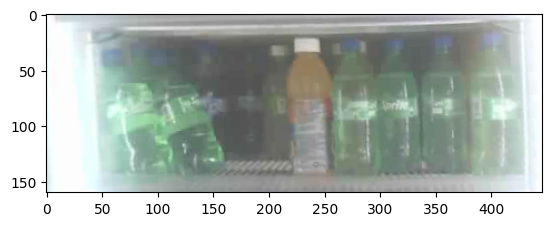

In [47]:
shelf = chiller.shelves[1]
plt.imshow(shelf.output_image);

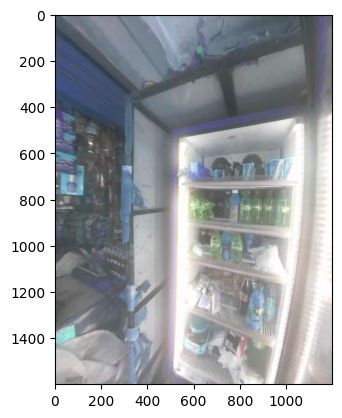

In [58]:
plt.imshow(shelf.image);

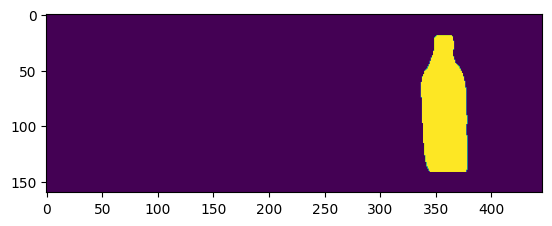

In [48]:
gray = np.zeros_like(cv2.cvtColor(shelf.output_image, cv2.COLOR_RGB2GRAY))
polygon = np.array(shelf.bottles[0].polygon)
mask = cv2.drawContours(gray, [polygon], -1, color=(255), thickness=cv2.FILLED) 
plt.imshow(mask)

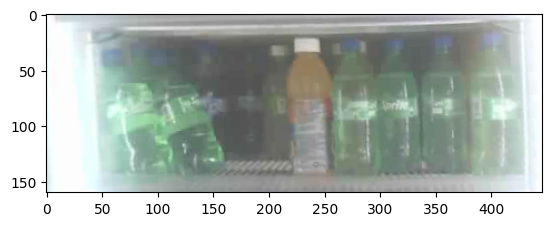

In [49]:
image = shelf.output_image
plt.imshow(image)

In [50]:
zeroes = np.zeros_like(shelf.output_image)
bottle = cv2.bitwise_and(image, image, mask=mask)

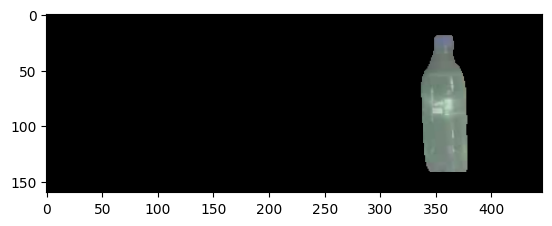

In [51]:
plt.imshow(bottle);

In [52]:
cv2.boundingRect(polygon)

(337, 19, 42, 123)

In [ ]:
she

In [17]:
site_data_path = "/media/akshay/datasets/coke/siteData"

In [17]:
shelf = chiller.shelves[0]

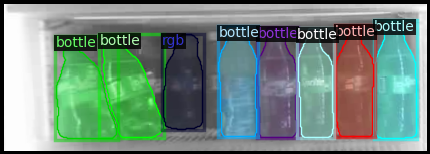

In [18]:
chiller.shelves[1].bottle_image

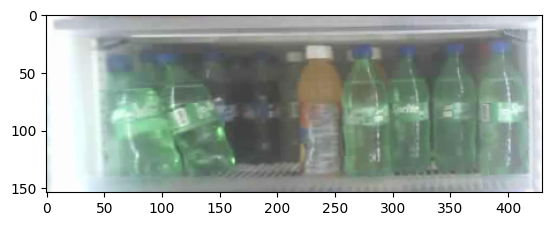

In [19]:
plt.imshow(chiller.shelves[1].output_image)

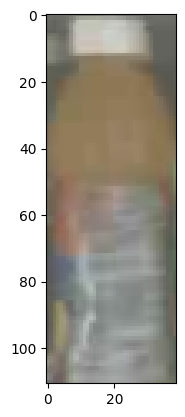

In [20]:
shelf = chiller.shelves[1]
image = shelf.output_image
mask = np.array(shelf.bottles[1].mask).astype(np.uint8)
bottle = cv2.bitwise_and(image, image, mask=mask)
x, y, w, h = cv2.boundingRect(mask)
sub = image[y: y+h, x: x+w]
plt.imshow(sub)

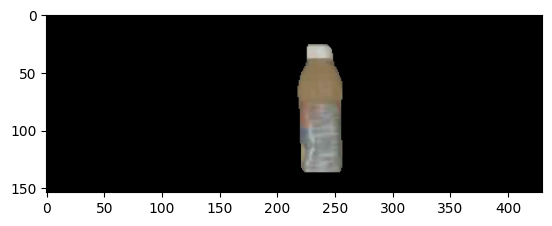

In [21]:
plt.imshow(bottle)

In [22]:
bottle = cv2.bitwise_and(image, image, mask=mask)

In [24]:
bottle_images = shelf.get_bottle_sub_images()

In [25]:
len(bottle_images)

8

In [26]:
for b in bottle_images:
    print(b.shape)

(111, 40, 3)
(111, 39, 3)
(110, 36, 3)
(112, 39, 3)
(119, 42, 3)
(100, 61, 3)
(99, 61, 3)
(96, 40, 3)


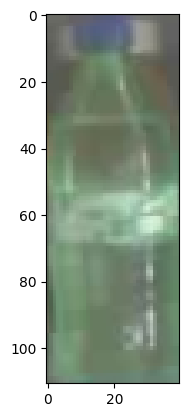

In [29]:
plt.imshow(bottle_images[0])

In [44]:
frame = video_manager.frame
frame

file  \
date                                                                     
1970-01-01 05:30:01  /media/akshay/datasets/coke/siteData/08F9E0ECC...   
1970-01-01 05:30:01  /media/akshay/datasets/coke/siteData/08F9E0ECC...   
1970-01-01 05:30:01  /media/akshay/datasets/coke/siteData/08F9E0ECC...   
1970-01-01 05:30:01  /media/akshay/datasets/coke/siteData/08F9E0ECC...   
1970-01-01 05:30:01  /media/akshay/datasets/coke/siteData/08F9E0ECC...   
...                                                                ...   
2024-07-18 18:45:44  /media/akshay/datasets/coke/siteData/08F9E0F67...   
2024-07-18 18:46:25  /media/akshay/datasets/coke/siteData/FCE8C0A77...   
2024-07-18 18:46:56  /media/akshay/datasets/coke/siteData/C82E18224...   
2024-07-18 18:47:59  /media/akshay/datasets/coke/siteData/FCE8C0A5D...   
2024-07-18 18:49:05  /media/akshay/datasets/coke/siteData/C82E18232...   

                                                              category  \
date                                                                     
1970-01-01 05:30:01  [glareOrFog, glareOrFog, glareOrFog, glareOrFo...   
1970-01-01 05:30:01  [glareOrFog, glareOrFog, glareOrFog, glareOrFo...   
1970-01-01 05:30:01  [glareOrFog, glareOrFog, glareOrFog, glareOrFo...   
1970-01-01 05:30:01                                               None   
1970-01-01 05:30:01  [top3Clear, glareOrFog, closedDoor, closedDoor...   
...                                                                ...   
2024-07-18 18:45:44  [closedDoor, closedDoor, closedDoor, closedDoo...   
2024-07-18 18:46:25  [closedDoor, closedDoor, closedDoor, closedDoo...   
2024-07-18 18:46:56  [closedDoor, closedDoor, closedDoor, closedDoo...   
2024-07-18 18:47:59  [closedDoor, closedDoor, closedDoor, closedDoo...   
2024-07-18 18:49:05  [closedDoor, closedDoor, closedDoor, closedDoo...   

                                                            confidence  \
date                                                                     
1970-01-01 05:30:01  [0.7777602076530457, 0.9414980411529541, 0.876...   
1970-01-01 05:30:01  [0.6693228483200073, 0.586540937423706, 0.6931...   
1970-01-01 05:30:01  [0.7424008250236511, 0.7038099765777588, 0.767...   
1970-01-01 05:30:01                                               None   
1970-01-01 05:30:01  [0.35190311074256897, 0.6426095962524414, 0.97...   
...                                                                ...   
2024-07-18 18:45:44  [0.9999945163726807, 0.9999707937240601, 0.999...   
2024-07-18 18:46:25  [0.9999656677246094, 0.9999911785125732, 0.999...   
2024-07-18 18:46:56  [0.9999953508377075, 0.9999936819076538, 0.999...   
2024-07-18 18:47:59  [0.9999905824661255, 0.9999945163726807, 0.999...   
2024-07-18 18:49:05  [0.9930986762046814, 0.9972231388092041, 0.972...   

                    video_status                      store_name  \
date                                                               
1970-01-01 05:30:01   glareOrFog                Milan Tea Centre   
1970-01-01 05:30:01   glareOrFog                Milan Tea Centre   
1970-01-01 05:30:01   glareOrFog                Milan Tea Centre   
1970-01-01 05:30:01        error                Milan Tea Centre   
1970-01-01 05:30:01   closedDoor                Milan Tea Centre   
...                          ...                             ...   
2024-07-18 18:45:44   closedDoor  Gayatri Tea Store (Ahmad Raza)   
2024-07-18 18:46:25   closedDoor                            VG07   
2024-07-18 18:46:56   closedDoor                Rajal Dryfruits2   
2024-07-18 18:47:59   closedDoor                            VG05   
2024-07-18 18:49:05   closedDoor               Milan Tea Centre2   

                      store_asset_name        mac_id  
date                                                  
1970-01-01 05:30:01    9 Caser-Western  08F9E0ECCC24  
1970-01-01 05:30:01    9 Caser-Western  08F9E0ECCC24  
1970-01-01 05:30:01    9 Caser-Western  08F9E0ECCC24  
1970-01-01 05:30:

In [45]:
f = frame[frame.store_asset_name.apply(lambda x: x[0] in ['P', 'V'])]

In [46]:
f

file  \
date                                                                     
2024-05-23 12:51:36  /media/akshay/datasets/coke/siteData/C82E18224...   
2024-05-23 19:22:40  /media/akshay/datasets/coke/siteData/34987AB5F...   
2024-05-23 19:47:39  /media/akshay/datasets/coke/siteData/34987AB5F...   
2024-05-23 19:48:57  /media/akshay/datasets/coke/siteData/34987AB5F...   
2024-05-23 19:50:06  /media/akshay/datasets/coke/siteData/34987AB5F...   
...                                                                ...   
2024-07-18 18:44:09  /media/akshay/datasets/coke/siteData/FCE8C0A86...   
2024-07-18 18:45:30  /media/akshay/datasets/coke/siteData/08F9E0ECD...   
2024-07-18 18:45:44  /media/akshay/datasets/coke/siteData/08F9E0F67...   
2024-07-18 18:46:25  /media/akshay/datasets/coke/siteData/FCE8C0A77...   
2024-07-18 18:47:59  /media/akshay/datasets/coke/siteData/FCE8C0A5D...   

                                                              category  \
date                                                                     
2024-05-23 12:51:36  [glareOrFog, glareOrFog, glareOrFog, glareOrFo...   
2024-05-23 19:22:40  [glareOrFog, glareOrFog, glareOrFog, glareOrFo...   
2024-05-23 19:47:39  [tooObstructed, tooObstructed, tooObstructed, ...   
2024-05-23 19:48:57  [glareOrFog, glareOrFog, glareOrFog, glareOrFo...   
2024-05-23 19:50:06  [closedDoor, closedDoor, closedDoor, notOpenEn...   
...                                                                ...   
2024-07-18 18:44:09  [closedDoor, notOpenEnough, notOpenEnough, not...   
2024-07-18 18:45:30  [closedDoor, closedDoor, closedDoor, closedDoo...   
2024-07-18 18:45:44  [closedDoor, closedDoor, closedDoor, closedDoo...   
2024-07-18 18:46:25  [closedDoor, closedDoor, closedDoor, closedDoo...   
2024-07-18 18:47:59  [closedDoor, closedDoor, closedDoor, closedDoo...   

                                                            confidence  \
date                                                                     
2024-05-23 12:51:36  [0.7399184107780457, 0.6412422060966492, 0.648...   
2024-05-23 19:22:40  [0.520176887512207, 0.5224841833114624, 0.6451...   
2024-05-23 19:47:39  [0.708457887172699, 0.6574528813362122, 0.4173...   
2024-05-23 19:48:57  [0.9808001518249512, 0.9977814555168152, 0.996...   
2024-05-23 19:50:06  [0.9992081522941589, 0.9989595413208008, 0.992...   
...                                                                ...   
2024-07-18 18:44:09  [0.9979142546653748, 0.9796028733253479, 0.695...   
2024-07-18 18:45:30  [0.998976469039917, 0.9991329312324524, 0.9996...   
2024-07-18 18:45:44  [0.9999945163726807, 0.9999707937240601, 0.999...   
2024-07-18 18:46:25  [0.9999656677246094, 0.9999911785125732, 0.999...   
2024-07-18 18:47:59  [0.9999905824661255, 0.9999945163726807, 0.999...   

                    video_status                      store_name  \
date                                                               
2024-05-23 12:51:36   glareOrFog       Blissful Haven Heart Café   
2024-05-23 19:22:40   glareOrFog                 Darbar The Café   
2024-05-23 19:47:39   closedDoor                 Darbar The Café   
2024-05-23 19:48:57    top3Clear                 Darbar The Café   
2024-05-23 19:50:06    top3Clear                 Darbar The Café   
...                          ...                             ...   
2024-07-18 18:44:09    top3Clear                            VG04   
2024-07-18 18:45:30   closedDoor      Vijaylakshmi General Store   
2024-07-18 18:45:44   closedDoor  Gayatri Tea Store (Ahmad Raza)   
2024-07-18 18:46:25   closedDoor                            VG07   
2024-07-18 18:47:59   closedDoor                            VG05   

                    store_asset_name        mac_id  
date                                                
2024-05-23 12:51:36               P6  C82E1822446C  
2024-05-23 19:22:40               V1  34987AB5FCAC  
2024-05-23 19:47:39               V1  34987AB5FCAC  
2024-05-23 19:48:57        

In [47]:
f[f.file.apply(lambda x: not 'del' in x)].iloc[0].file

'/media/akshay/datasets/coke/siteData/C82E1822446C/20240523/C82E1822446C_1716448896349_00.avi'

<Axes: ylabel='count'>

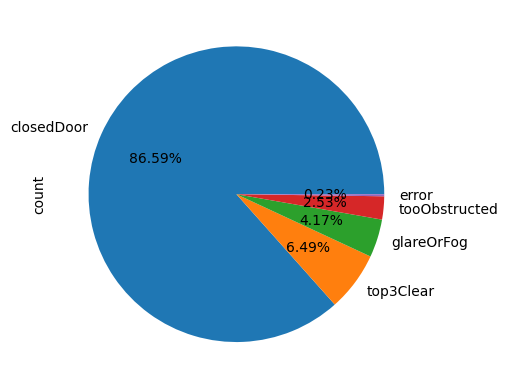

In [48]:
frame.video_status.value_counts().plot(kind='pie', autopct='%1.2f%%')

<Axes: ylabel='count'>

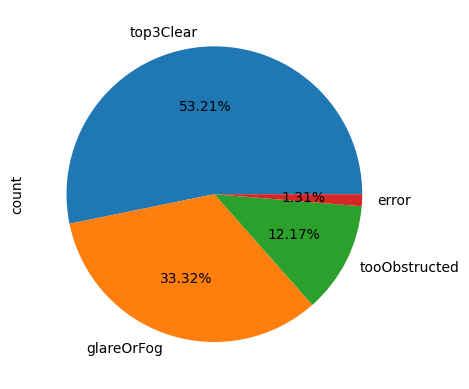

In [51]:
good = f[f.video_status != 'closedDoor']
good.video_status.value_counts().plot(kind='pie', autopct='%1.2f%%')

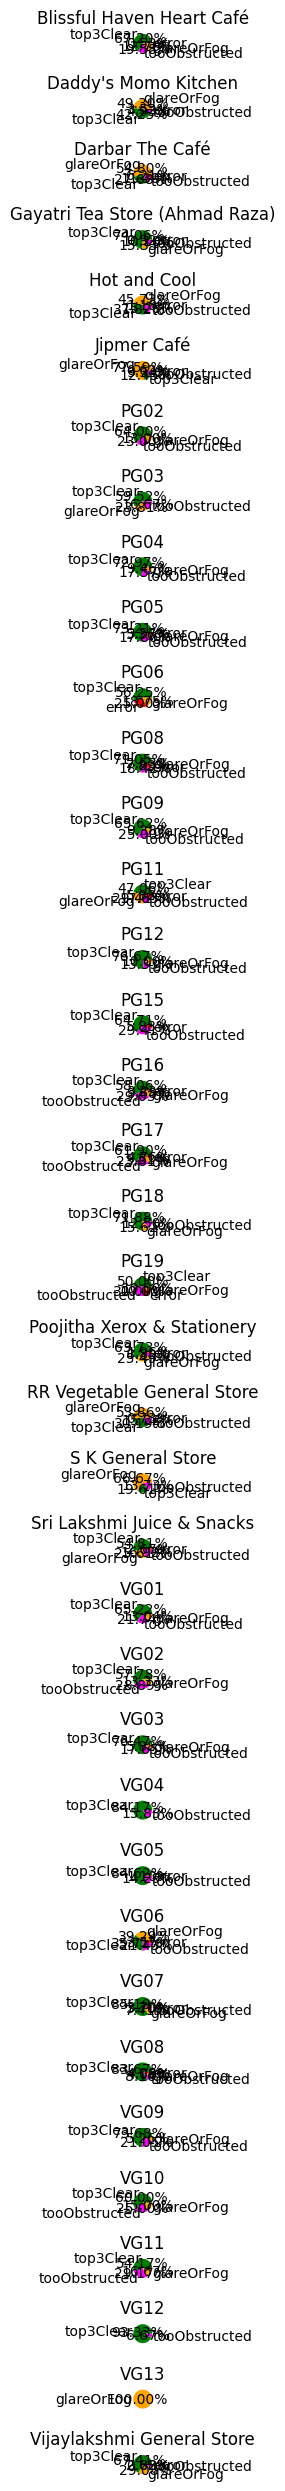

In [52]:
color_map = {
    'top3Clear': 'green',
    'glareOrFog': 'orange',
    'error': 'red',
    'tooObstructed': 'magenta'
}

grouped = good.groupby('store_name')
fig, axes = plt.subplots(nrows=len(grouped), ncols=1, figsize=(35, 25))

for (key, ax) in zip(grouped.groups.keys(), axes.flatten()):
    value_counts = grouped.get_group(key).video_status.value_counts()
    grouped.get_group(key).video_status.value_counts().plot(kind='pie', 
                                                            autopct='%1.2f%%', 
                                                            ax=ax, 
                                                            title=key,
                                                           colors=[color_map[v] for v in value_counts.index])
    ax.set_ylabel('')  # Remove the default ylabel

# Adjust layout
plt.tight_layout()

In [53]:
good.groupby('video_status').groups.keys()

dict_keys(['error', 'glareOrFog', 'tooObstructed', 'top3Clear'])

In [54]:
grouped.get_group(key).video_status.value_counts()

video_status
top3Clear        904
glareOrFog       390
tooObstructed     36
error             11
Name: count, dtype: int64

In [57]:
frame.video_status.value_counts()

video_status
closedDoor       69435
top3Clear         5206
glareOrFog        3343
tooObstructed     2026
error              181
Name: count, dtype: int64

<Axes: xlabel='store_asset_name'>

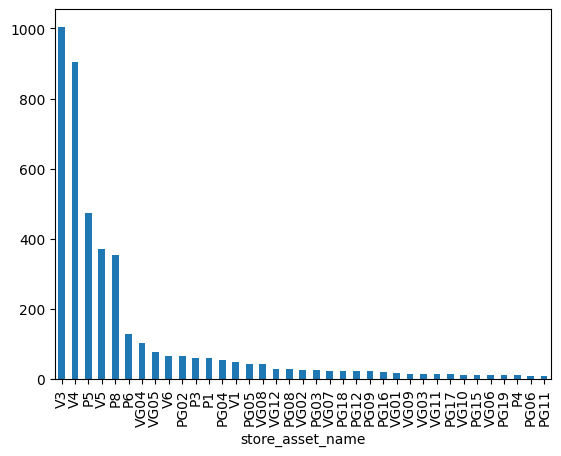

In [55]:
good[good.video_status == 'top3Clear'].store_asset_name.value_counts().plot(kind='bar')

In [49]:
good[good.video_status == 'tooFoggy'].store_asset_name.value_counts().plot(kind='bar')

NameError: name 'good' is not defined

In [16]:
top3 = video_manager.get_top3_frame()

In [62]:
def is_asset_of_interest(x):
    if x[0] in ["V", "G"]:
        return True
    return False

In [63]:
frame[video_manager.frame.store_asset_name.apply(is_asset_of_interest)]

file  \
date                                                                     
2024-05-23 19:22:40  /media/akshay/datasets/coke/siteData/34987AB5F...   
2024-05-23 19:47:39  /media/akshay/datasets/coke/siteData/34987AB5F...   
2024-05-23 19:48:57  /media/akshay/datasets/coke/siteData/34987AB5F...   
2024-05-23 19:50:06  /media/akshay/datasets/coke/siteData/34987AB5F...   
2024-05-23 19:51:28  /media/akshay/datasets/coke/siteData/34987AB5F...   
...                                                                ...   
2024-07-18 18:44:09  /media/akshay/datasets/coke/siteData/FCE8C0A86...   
2024-07-18 18:45:30  /media/akshay/datasets/coke/siteData/08F9E0ECD...   
2024-07-18 18:45:44  /media/akshay/datasets/coke/siteData/08F9E0F67...   
2024-07-18 18:46:25  /media/akshay/datasets/coke/siteData/FCE8C0A77...   
2024-07-18 18:47:59  /media/akshay/datasets/coke/siteData/FCE8C0A5D...   

                                                              category  \
date                                                                     
2024-05-23 19:22:40  [glareOrFog, glareOrFog, glareOrFog, glareOrFo...   
2024-05-23 19:47:39  [tooObstructed, tooObstructed, tooObstructed, ...   
2024-05-23 19:48:57  [glareOrFog, glareOrFog, glareOrFog, glareOrFo...   
2024-05-23 19:50:06  [closedDoor, closedDoor, closedDoor, notOpenEn...   
2024-05-23 19:51:28  [top3Clear, top3Clear, top3Clear, top3Clear, t...   
...                                                                ...   
2024-07-18 18:44:09  [closedDoor, notOpenEnough, notOpenEnough, not...   
2024-07-18 18:45:30  [closedDoor, closedDoor, closedDoor, closedDoo...   
2024-07-18 18:45:44  [closedDoor, closedDoor, closedDoor, closedDoo...   
2024-07-18 18:46:25  [closedDoor, closedDoor, closedDoor, closedDoo...   
2024-07-18 18:47:59  [closedDoor, closedDoor, closedDoor, closedDoo...   

                                                            confidence  \
date                                                                     
2024-05-23 19:22:40  [0.520176887512207, 0.5224841833114624, 0.6451...   
2024-05-23 19:47:39  [0.708457887172699, 0.6574528813362122, 0.4173...   
2024-05-23 19:48:57  [0.9808001518249512, 0.9977814555168152, 0.996...   
2024-05-23 19:50:06  [0.9992081522941589, 0.9989595413208008, 0.992...   
2024-05-23 19:51:28  [0.5013653635978699, 0.5936216115951538, 0.787...   
...                                                                ...   
2024-07-18 18:44:09  [0.9979142546653748, 0.9796028733253479, 0.695...   
2024-07-18 18:45:30  [0.998976469039917, 0.9991329312324524, 0.9996...   
2024-07-18 18:45:44  [0.9999945163726807, 0.9999707937240601, 0.999...   
2024-07-18 18:46:25  [0.9999656677246094, 0.9999911785125732, 0.999...   
2024-07-18 18:47:59  [0.9999905824661255, 0.9999945163726807, 0.999...   

                    video_status                      store_name  \
date                                                               
2024-05-23 19:22:40   glareOrFog                 Darbar The Café   
2024-05-23 19:47:39   closedDoor                 Darbar The Café   
2024-05-23 19:48:57    top3Clear                 Darbar The Café   
2024-05-23 19:50:06    top3Clear                 Darbar The Café   
2024-05-23 19:51:28    top3Clear                 Darbar The Café   
...                          ...                             ...   
2024-07-18 18:44:09    top3Clear                            VG04   
2024-07-18 18:45:30   closedDoor      Vijaylakshmi General Store   
2024-07-18 18:45:44   closedDoor  Gayatri Tea Store (Ahmad Raza)   
2024-07-18 18:46:25   closedDoor                            VG07   
2024-07-18 18:47:59   closedDoor                            VG05   

                    store_asset_name        mac_id  
date                                                
2024-05-23 19:22:40               V1  34987AB5FCAC  
2024-05-23 19:47:39               V1  34987AB5FCAC  
2024-05-23 19:48:57               V1  34987AB5FCAC  
2024-05-23 19:50:06        

In [17]:
top3

file  \
date                                                                     
2024-07-08 18:34:00  /media/akshay/datasets/coke/siteData/C82E18224...   
2024-07-08 18:58:48  /media/akshay/datasets/coke/siteData/C82E18224...   
2024-07-08 19:30:37  /media/akshay/datasets/coke/siteData/C82E18224...   
2024-07-08 18:07:43  /media/akshay/datasets/coke/siteData/C82E18224...   
2024-07-08 20:54:27  /media/akshay/datasets/coke/siteData/C82E18224...   
...                                                                ...   
2024-05-31 19:25:13  /media/akshay/datasets/coke/siteData/C82E18223...   
2024-06-09 14:40:10  /media/akshay/datasets/coke/siteData/C82E18223...   
2024-06-09 15:20:24  /media/akshay/datasets/coke/siteData/C82E18223...   
2024-06-09 11:54:47  /media/akshay/datasets/coke/siteData/C82E18223...   
2024-06-09 11:57:24  /media/akshay/datasets/coke/siteData/C82E18223...   

                                                              category  \
date                                                                     
2024-07-08 18:34:00  [closedDoor, closedDoor, closedDoor, closedDoo...   
2024-07-08 18:58:48  [closedDoor, closedDoor, closedDoor, closedDoo...   
2024-07-08 19:30:37  [closedDoor, closedDoor, closedDoor, closedDoo...   
2024-07-08 18:07:43  [closedDoor, closedDoor, closedDoor, closedDoo...   
2024-07-08 20:54:27  [closedDoor, closedDoor, closedDoor, closedDoo...   
...                                                                ...   
2024-05-31 19:25:13  [closedDoor, closedDoor, closedDoor, closedDoo...   
2024-06-09 14:40:10  [top3Clear, top3Clear, top3Clear, top3Clear, t...   
2024-06-09 15:20:24  [closedDoor, closedDoor, notOpenEnough, top3Cl...   
2024-06-09 11:54:47  [closedDoor, closedDoor, closedDoor, notOpenEn...   
2024-06-09 11:57:24  [top3Clear, top3Clear, top3Clear, top3Clear, t...   

                                                            confidence  \
date                                                                     
2024-07-08 18:34:00  [0.9999978542327881, 0.9999983310699463, 0.999...   
2024-07-08 18:58:48  [0.9999991655349731, 0.9999982118606567, 0.999...   
2024-07-08 19:30:37  [0.9999986886978149, 0.9999676942825317, 0.995...   
2024-07-08 18:07:43  [0.9999886751174927, 0.9999837875366211, 0.649...   
2024-07-08 20:54:27  [1.0, 1.0, 0.9999998807907104, 1.0, 0.99942553...   
...                                                                ...   
2024-05-31 19:25:13  [0.9999979734420776, 0.9999957084655762, 0.999...   
2024-06-09 14:40:10  [0.9375025629997253, 0.8436301946640015, 0.915...   
2024-06-09 15:20:24  [0.999981164932251, 0.9350219964981079, 0.9259...   
2024-06-09 11:54:47  [0.9999998807907104, 0.9999996423721313, 0.999...   
2024-06-09 11:57:24  [0.65878826379776, 0.8422577977180481, 0.84394...   

                    video_status        store_name   store_asset_name  \
date                                                                    
2024-07-08 18:34:00    top3Clear  Rajal Dryfruits2  14 Caser-Western2   
2024-07-08 18:58:48    top3Clear  Rajal Dryfruits2  14 Caser-Western2   
2024-07-08 19:30:37    top3Clear  Rajal Dryfruits2  14 Caser-Western2   
2024-07-08 18:07:43    top3Clear  Rajal Dryfruits2  14 Caser-Western2   
2024-07-08 20:54:27    top3Clear  Rajal Dryfruits2  14 Caser-Western2   
...                          ...               ...                ...   
2024-05-31 19:25:13    top3Clear      Hot and Cool                 P8   
2024-06-09 14:40:10    top3Clear      Hot and Cool                 P8   
2024-06-09 15:20:24    top3Clear      Hot and Cool                 P8   
2024-06-09 11:54:47    top3Clear      Hot and Cool                 P8   
2024-06-09 11:57:24    top3Clear      Hot and Cool                 P8   

                           mac_id  
date                               
2024-07-08 18:34:00  C82E18224378  
2024-07-08 18:58:48  C82E18224378  
2024-07-08 19:30:37  C82E18224378  
2024-07-08 18:07:43  C82E18224378  
2024-07-08 

In [73]:
frame

file  \
date                                                                     
1970-01-01 05:30:01  /media/akshay/datasets/coke/siteData/08F9E0ECC...   
1970-01-01 05:30:01  /media/akshay/datasets/coke/siteData/08F9E0ECC...   
1970-01-01 05:30:01  /media/akshay/datasets/coke/siteData/08F9E0ECC...   
1970-01-01 05:30:01  /media/akshay/datasets/coke/siteData/08F9E0ECC...   
1970-01-01 05:30:01  /media/akshay/datasets/coke/siteData/08F9E0ECC...   
...                                                                ...   
2024-07-18 18:45:44  /media/akshay/datasets/coke/siteData/08F9E0F67...   
2024-07-18 18:46:25  /media/akshay/datasets/coke/siteData/FCE8C0A77...   
2024-07-18 18:46:56  /media/akshay/datasets/coke/siteData/C82E18224...   
2024-07-18 18:47:59  /media/akshay/datasets/coke/siteData/FCE8C0A5D...   
2024-07-18 18:49:05  /media/akshay/datasets/coke/siteData/C82E18232...   

                                                              category  \
date                                                                     
1970-01-01 05:30:01  [glareOrFog, glareOrFog, glareOrFog, glareOrFo...   
1970-01-01 05:30:01  [glareOrFog, glareOrFog, glareOrFog, glareOrFo...   
1970-01-01 05:30:01  [glareOrFog, glareOrFog, glareOrFog, glareOrFo...   
1970-01-01 05:30:01                                               None   
1970-01-01 05:30:01  [top3Clear, glareOrFog, closedDoor, closedDoor...   
...                                                                ...   
2024-07-18 18:45:44  [closedDoor, closedDoor, closedDoor, closedDoo...   
2024-07-18 18:46:25  [closedDoor, closedDoor, closedDoor, closedDoo...   
2024-07-18 18:46:56  [closedDoor, closedDoor, closedDoor, closedDoo...   
2024-07-18 18:47:59  [closedDoor, closedDoor, closedDoor, closedDoo...   
2024-07-18 18:49:05  [closedDoor, closedDoor, closedDoor, closedDoo...   

                                                            confidence  \
date                                                                     
1970-01-01 05:30:01  [0.7777602076530457, 0.9414980411529541, 0.876...   
1970-01-01 05:30:01  [0.6693228483200073, 0.586540937423706, 0.6931...   
1970-01-01 05:30:01  [0.7424008250236511, 0.7038099765777588, 0.767...   
1970-01-01 05:30:01                                               None   
1970-01-01 05:30:01  [0.35190311074256897, 0.6426095962524414, 0.97...   
...                                                                ...   
2024-07-18 18:45:44  [0.9999945163726807, 0.9999707937240601, 0.999...   
2024-07-18 18:46:25  [0.9999656677246094, 0.9999911785125732, 0.999...   
2024-07-18 18:46:56  [0.9999953508377075, 0.9999936819076538, 0.999...   
2024-07-18 18:47:59  [0.9999905824661255, 0.9999945163726807, 0.999...   
2024-07-18 18:49:05  [0.9930986762046814, 0.9972231388092041, 0.972...   

                    video_status                      store_name  \
date                                                               
1970-01-01 05:30:01   glareOrFog                Milan Tea Centre   
1970-01-01 05:30:01   glareOrFog                Milan Tea Centre   
1970-01-01 05:30:01   glareOrFog                Milan Tea Centre   
1970-01-01 05:30:01        error                Milan Tea Centre   
1970-01-01 05:30:01   closedDoor                Milan Tea Centre   
...                          ...                             ...   
2024-07-18 18:45:44   closedDoor  Gayatri Tea Store (Ahmad Raza)   
2024-07-18 18:46:25   closedDoor                            VG07   
2024-07-18 18:46:56   closedDoor                Rajal Dryfruits2   
2024-07-18 18:47:59   closedDoor                            VG05   
2024-07-18 18:49:05   closedDoor               Milan Tea Centre2   

                      store_asset_name        mac_id  
date                                                  
1970-01-01 05:30:01    9 Caser-Western  08F9E0ECCC24  
1970-01-01 05:30:01    9 Caser-Western  08F9E0ECCC24  
1970-01-01 05:30:01    9 Caser-Western  08F9E0ECCC24  
1970-01-01 05:30:

<Axes: xlabel='store_asset_name'>

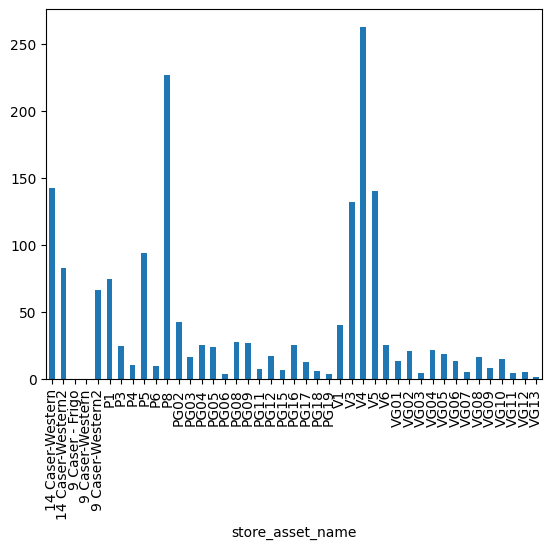

In [78]:
daily_counts = frame.groupby('store_asset_name').resample('D').size()
average_videos_per_day = daily_counts.groupby('store_asset_name').mean()
average_videos_per_day_df = average_videos_per_day.reset_index(name='average_videos_per_day')
average_videos_per_day.plot(kind='bar')

In [80]:
max(frame.index)

Timestamp('2024-07-18 18:49:05')

<Axes: xlabel='store_asset_name'>

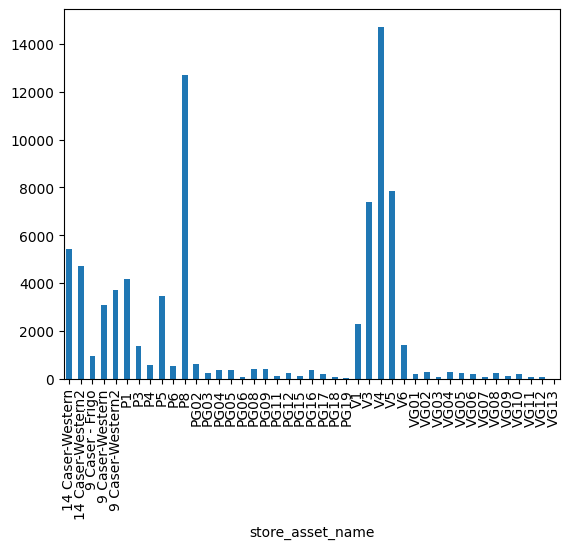

In [68]:
frame.store_asset_name.value_counts().sort_index().plot(kind='bar')

In [86]:
store_frame = frame[frame.store_asset_name == 'V4']
daily_counts = store_frame.groupby('video_status').resample('D').size()
daily_counts

video_status  date      
closedDoor    2024-05-24      7
              2024-05-25      5
              2024-05-26      1
              2024-05-27      0
              2024-05-28    175
                           ... 
top3Clear     2024-07-13      4
              2024-07-14      8
              2024-07-15      0
              2024-07-16      5
              2024-07-17     25
Length: 269, dtype: int64

In [93]:
daily_counts.reset_index(name='daily_stats')
daily_counts.set_index('date', inplace=True)

AttributeError: 'Series' object has no attribute 'set_index'

In [84]:
df = daily_counts.reset_index(name='daily_stats')
df.plot(kind='bar')

date
2024-05-24     10
2024-05-25      8
2024-05-26      1
2024-05-27      0
2024-05-28    212
2024-05-29    373
2024-05-30    310
2024-05-31    424
2024-06-01    244
2024-06-02    283
2024-06-03    321
2024-06-04    355
2024-06-05    339
2024-06-06    321
2024-06-07    359
2024-06-08    209
2024-06-09    314
2024-06-10    335
2024-06-11    306
2024-06-12    493
2024-06-13    108
2024-06-14    379
2024-06-15    386
2024-06-16    448
2024-06-17    396
2024-06-18    333
2024-06-19    243
2024-06-20    304
2024-06-21    418
2024-06-22    258
2024-06-23    451
2024-06-24    334
2024-06-25    311
2024-06-26    362
2024-06-27    356
2024-06-28    264
2024-06-29    243
2024-06-30    369
2024-07-01    345
2024-07-02    110
2024-07-03    240
2024-07-04    287
2024-07-05    306
2024-07-06    287
2024-07-07    257
2024-07-08    322
2024-07-09    190
2024-07-10    112
2024-07-11    129
2024-07-12     73
2024-07-13     75
2024-07-14    145
2024-07-15     23
2024-07-16    179
2024-07-17    303
2024-

In [94]:
import pandas as pd

# Assuming 'frame' is your DataFrame and contains a datetime index
store_frame = frame[frame['store_asset_name'] == 'V4']

# Group by 'video_status' and resample daily
daily_counts = store_frame.groupby('video_status').resample('D').size()

# Reset index and name the count column
daily_counts = daily_counts.reset_index(name='daily_stats')
daily_counts.set_index('date', inplace=True)

<Axes: xlabel='date'>

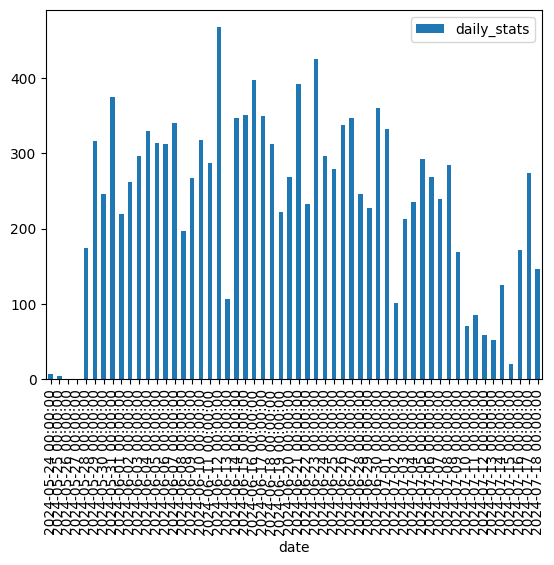

In [107]:
daily_counts[daily_counts.video_status == 'closedDoor'].plot(kind='bar')

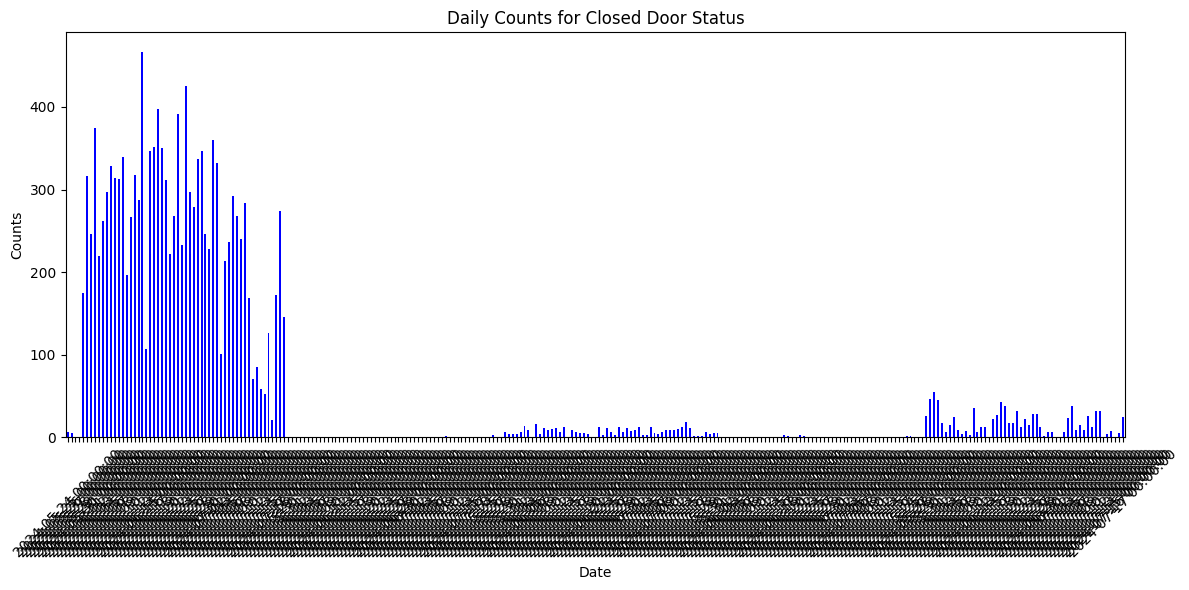

In [109]:
plt.figure(figsize=(12, 6))  # Increase the size of the plot
daily_counts['daily_stats'].plot(kind='bar', color='blue')
plt.xticks(rotation=45)  # Rotate date labels to 45 degrees
plt.xlabel('Date')
plt.ylabel('Counts')
plt.title('Daily Counts for Closed Door Status')
plt.tight_layout()  # Adjust layout to make room for label rotation
plt.show()

IndexError: index 0 is out of bounds for axis 0 with size 0

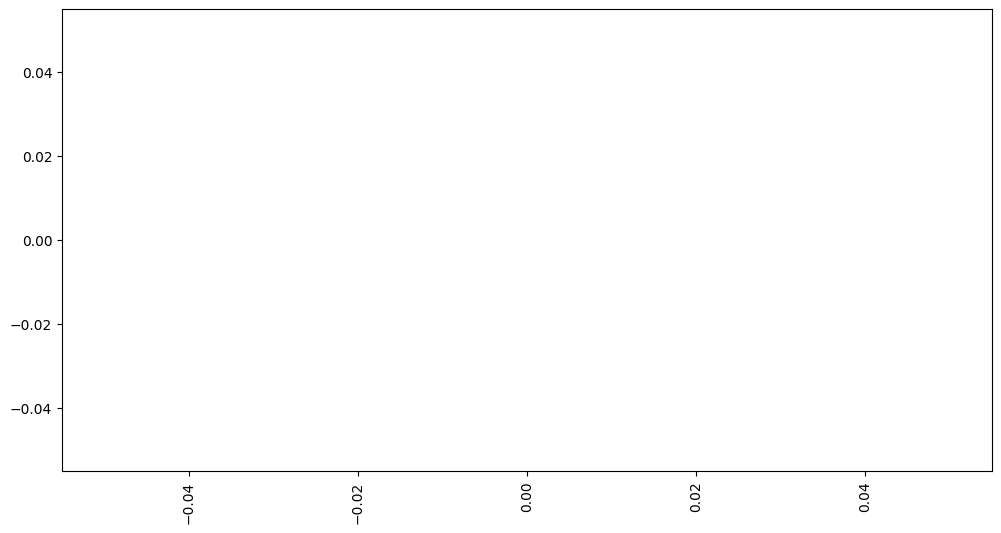

In [121]:
store_frame = frame[frame['store_asset_name'] == 'V4']
daily_counts = store_frame.groupby('video_status').resample('D').size()
daily_counts = daily_counts.reset_index(name='daily_stats')
daily_counts.set_index('date', inplace=True)
daily_counts.index = daily_counts.index.date
daily_counts = daily_counts[daily_counts.video_status == 'closedDoor']
max_date = daily_counts.index.max()  # Get the maximum date in your dataset
date_range = pd.date_range(max_date - pd.Timedelta(days=10), max_date) 
range_frame = daily_counts.loc[daily_counts.index.isin(date_range)]

plt.figure(figsize=(12, 6))
range_frame['daily_stats'].plot(kind='bar', color='blue')
plt.xlabel('Date (MM-DD)')
plt.ylabel('Counts')
plt.title('Daily Counts for Closed Door Status')
plt.tight_layout()  # Adjust layout to make room for label rotation
plt.show()

Last 10 Entries Data:            video_status  daily_stats
2024-07-09   closedDoor          169
2024-07-10   closedDoor           71
2024-07-11   closedDoor           85
2024-07-12   closedDoor           59
2024-07-13   closedDoor           52
2024-07-14   closedDoor          126
2024-07-15   closedDoor           21
2024-07-16   closedDoor          172
2024-07-17   closedDoor          274
2024-07-18   closedDoor          146


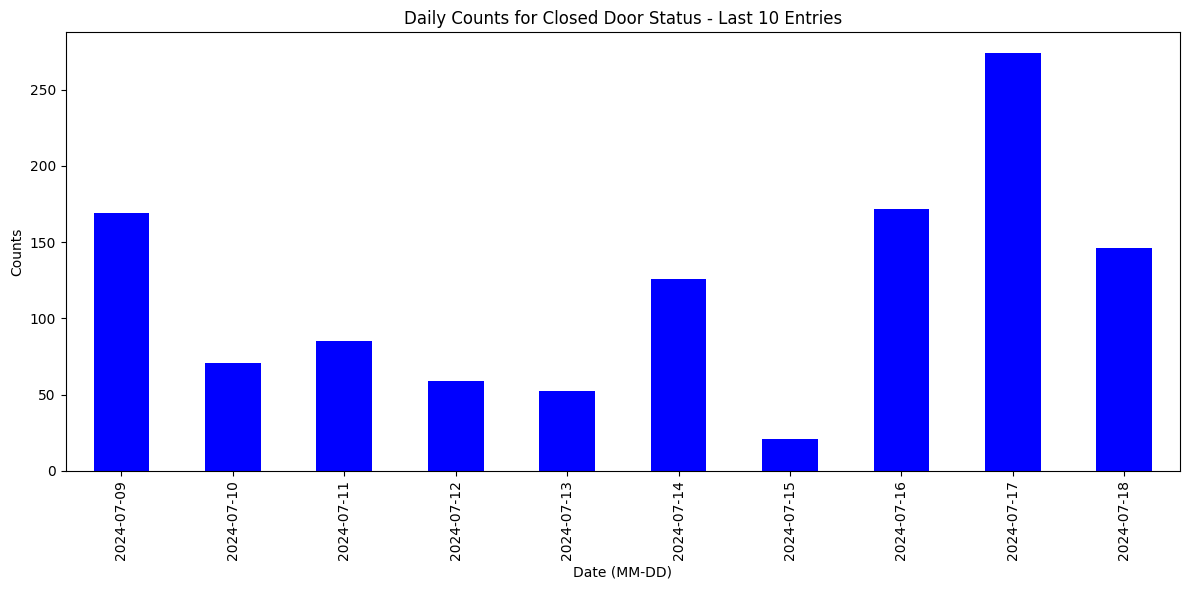

In [123]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming 'frame' is already defined and processed earlier
store_frame = frame[frame['store_asset_name'] == 'V4']
daily_counts = store_frame.groupby('video_status').resample('D').size()
daily_counts = daily_counts.reset_index(name='daily_stats')
daily_counts.set_index('date', inplace=True)
daily_counts.index = daily_counts.index.date
daily_counts = daily_counts[daily_counts.video_status == 'closedDoor']

# Get the last 10 entries instead of the last 10 days
last_10_entries = daily_counts.tail(10)

# Check the last 10 entries
print("Last 10 Entries Data:", last_10_entries)

if not last_10_entries.empty:
    plt.figure(figsize=(12, 6))
    last_10_entries['daily_stats'].plot(kind='bar', color='blue')
    plt.xlabel('Date (MM-DD)')
    plt.ylabel('Counts')
    plt.title('Daily Counts for Closed Door Status - Last 10 Entries')
    plt.tight_layout()  # Adjust layout to make room for label rotation
    plt.show()
else:
    print("No data available in the last 10 entries.")

In [128]:
frame

file  \
date                                                                     
1970-01-01 05:30:01  /media/akshay/datasets/coke/siteData/08F9E0ECC...   
1970-01-01 05:30:01  /media/akshay/datasets/coke/siteData/08F9E0ECC...   
1970-01-01 05:30:01  /media/akshay/datasets/coke/siteData/08F9E0ECC...   
1970-01-01 05:30:01  /media/akshay/datasets/coke/siteData/08F9E0ECC...   
1970-01-01 05:30:01  /media/akshay/datasets/coke/siteData/08F9E0ECC...   
...                                                                ...   
2024-07-18 18:45:44  /media/akshay/datasets/coke/siteData/08F9E0F67...   
2024-07-18 18:46:25  /media/akshay/datasets/coke/siteData/FCE8C0A77...   
2024-07-18 18:46:56  /media/akshay/datasets/coke/siteData/C82E18224...   
2024-07-18 18:47:59  /media/akshay/datasets/coke/siteData/FCE8C0A5D...   
2024-07-18 18:49:05  /media/akshay/datasets/coke/siteData/C82E18232...   

                                                              category  \
date                                                                     
1970-01-01 05:30:01  [glareOrFog, glareOrFog, glareOrFog, glareOrFo...   
1970-01-01 05:30:01  [glareOrFog, glareOrFog, glareOrFog, glareOrFo...   
1970-01-01 05:30:01  [glareOrFog, glareOrFog, glareOrFog, glareOrFo...   
1970-01-01 05:30:01                                               None   
1970-01-01 05:30:01  [top3Clear, glareOrFog, closedDoor, closedDoor...   
...                                                                ...   
2024-07-18 18:45:44  [closedDoor, closedDoor, closedDoor, closedDoo...   
2024-07-18 18:46:25  [closedDoor, closedDoor, closedDoor, closedDoo...   
2024-07-18 18:46:56  [closedDoor, closedDoor, closedDoor, closedDoo...   
2024-07-18 18:47:59  [closedDoor, closedDoor, closedDoor, closedDoo...   
2024-07-18 18:49:05  [closedDoor, closedDoor, closedDoor, closedDoo...   

                                                            confidence  \
date                                                                     
1970-01-01 05:30:01  [0.7777602076530457, 0.9414980411529541, 0.876...   
1970-01-01 05:30:01  [0.6693228483200073, 0.586540937423706, 0.6931...   
1970-01-01 05:30:01  [0.7424008250236511, 0.7038099765777588, 0.767...   
1970-01-01 05:30:01                                               None   
1970-01-01 05:30:01  [0.35190311074256897, 0.6426095962524414, 0.97...   
...                                                                ...   
2024-07-18 18:45:44  [0.9999945163726807, 0.9999707937240601, 0.999...   
2024-07-18 18:46:25  [0.9999656677246094, 0.9999911785125732, 0.999...   
2024-07-18 18:46:56  [0.9999953508377075, 0.9999936819076538, 0.999...   
2024-07-18 18:47:59  [0.9999905824661255, 0.9999945163726807, 0.999...   
2024-07-18 18:49:05  [0.9930986762046814, 0.9972231388092041, 0.972...   

                    video_status                      store_name  \
date                                                               
1970-01-01 05:30:01   glareOrFog                Milan Tea Centre   
1970-01-01 05:30:01   glareOrFog                Milan Tea Centre   
1970-01-01 05:30:01   glareOrFog                Milan Tea Centre   
1970-01-01 05:30:01        error                Milan Tea Centre   
1970-01-01 05:30:01   closedDoor                Milan Tea Centre   
...                          ...                             ...   
2024-07-18 18:45:44   closedDoor  Gayatri Tea Store (Ahmad Raza)   
2024-07-18 18:46:25   closedDoor                            VG07   
2024-07-18 18:46:56   closedDoor                Rajal Dryfruits2   
2024-07-18 18:47:59   closedDoor                            VG05   
2024-07-18 18:49:05   closedDoor               Milan Tea Centre2   

                      store_asset_name        mac_id  
date                                                  
1970-01-01 05:30:01    9 Caser-Western  08F9E0ECCC24  
1970-01-01 05:30:01    9 Caser-Western  08F9E0ECCC24  
1970-01-01 05:30:01    9 Caser-Western  08F9E0ECCC24  
1970-01-01 05:30:

<Figure size 1200x600 with 0 Axes>

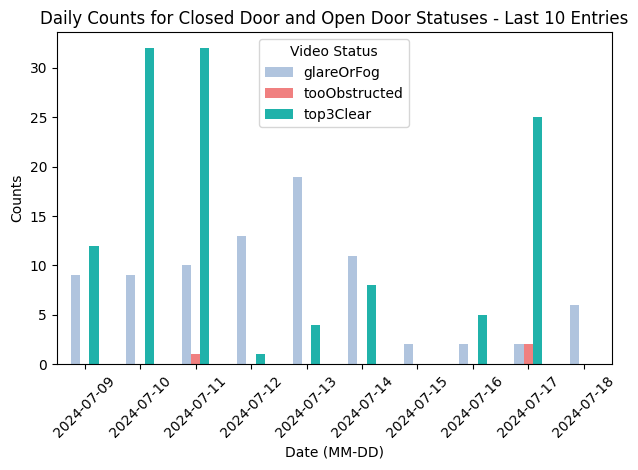

In [139]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming 'frame' is already defined and processed earlier
f = frame[frame.video_status != 'closedDoor']
f = f[f.video_status != 'error']
store_frame = f[f['store_asset_name'] == 'V4']
daily_counts = store_frame.groupby(['video_status', pd.Grouper(freq='D')]).size()
daily_counts = daily_counts.reset_index(name='daily_stats')
daily_counts.set_index('date', inplace=True)
daily_counts.index = daily_counts.index.date

# Pivot the table to have dates as index and video statuses as columns
pivot_table = daily_counts.pivot(columns='video_status', values='daily_stats')

# Check the pivot table
# print("Pivot Table Data:", pivot_table)

# Filter to get only the last 10 entries for plotting
last_10_entries = pivot_table.tail(10)

if not last_10_entries.empty:
    plt.figure(figsize=(12, 6))
    color_dict = {'openDoor': 'azure', 'glareOrFog': 'lightSteelBlue', 'tooObstructed': 'lightCoral', 'top3Clear': 'lightSeaGreen'}
    last_10_entries.plot(kind='bar', color=color_dict)  # Assuming two colors for two statuses
    plt.xlabel('Date (MM-DD)')
    plt.ylabel('Counts')
    plt.title('Daily Counts for Closed Door and Open Door Statuses - Last 10 Entries')
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.tight_layout()  # Adjust layout to make room for label rotation
    plt.legend(title='Video Status')
    plt.show()
else:
    print("No data available in the last 10 entries.")

In [131]:
set(f.video_status.tolist())

{'glareOrFog', 'tooObstructed', 'top3Clear'}

In [140]:
frame

file  \
date                                                                     
1970-01-01 05:30:01  /media/akshay/datasets/coke/siteData/08F9E0ECC...   
1970-01-01 05:30:01  /media/akshay/datasets/coke/siteData/08F9E0ECC...   
1970-01-01 05:30:01  /media/akshay/datasets/coke/siteData/08F9E0ECC...   
1970-01-01 05:30:01  /media/akshay/datasets/coke/siteData/08F9E0ECC...   
1970-01-01 05:30:01  /media/akshay/datasets/coke/siteData/08F9E0ECC...   
...                                                                ...   
2024-07-18 18:45:44  /media/akshay/datasets/coke/siteData/08F9E0F67...   
2024-07-18 18:46:25  /media/akshay/datasets/coke/siteData/FCE8C0A77...   
2024-07-18 18:46:56  /media/akshay/datasets/coke/siteData/C82E18224...   
2024-07-18 18:47:59  /media/akshay/datasets/coke/siteData/FCE8C0A5D...   
2024-07-18 18:49:05  /media/akshay/datasets/coke/siteData/C82E18232...   

                                                              category  \
date                                                                     
1970-01-01 05:30:01  [glareOrFog, glareOrFog, glareOrFog, glareOrFo...   
1970-01-01 05:30:01  [glareOrFog, glareOrFog, glareOrFog, glareOrFo...   
1970-01-01 05:30:01  [glareOrFog, glareOrFog, glareOrFog, glareOrFo...   
1970-01-01 05:30:01                                               None   
1970-01-01 05:30:01  [top3Clear, glareOrFog, closedDoor, closedDoor...   
...                                                                ...   
2024-07-18 18:45:44  [closedDoor, closedDoor, closedDoor, closedDoo...   
2024-07-18 18:46:25  [closedDoor, closedDoor, closedDoor, closedDoo...   
2024-07-18 18:46:56  [closedDoor, closedDoor, closedDoor, closedDoo...   
2024-07-18 18:47:59  [closedDoor, closedDoor, closedDoor, closedDoo...   
2024-07-18 18:49:05  [closedDoor, closedDoor, closedDoor, closedDoo...   

                                                            confidence  \
date                                                                     
1970-01-01 05:30:01  [0.7777602076530457, 0.9414980411529541, 0.876...   
1970-01-01 05:30:01  [0.6693228483200073, 0.586540937423706, 0.6931...   
1970-01-01 05:30:01  [0.7424008250236511, 0.7038099765777588, 0.767...   
1970-01-01 05:30:01                                               None   
1970-01-01 05:30:01  [0.35190311074256897, 0.6426095962524414, 0.97...   
...                                                                ...   
2024-07-18 18:45:44  [0.9999945163726807, 0.9999707937240601, 0.999...   
2024-07-18 18:46:25  [0.9999656677246094, 0.9999911785125732, 0.999...   
2024-07-18 18:46:56  [0.9999953508377075, 0.9999936819076538, 0.999...   
2024-07-18 18:47:59  [0.9999905824661255, 0.9999945163726807, 0.999...   
2024-07-18 18:49:05  [0.9930986762046814, 0.9972231388092041, 0.972...   

                    video_status                      store_name  \
date                                                               
1970-01-01 05:30:01   glareOrFog                Milan Tea Centre   
1970-01-01 05:30:01   glareOrFog                Milan Tea Centre   
1970-01-01 05:30:01   glareOrFog                Milan Tea Centre   
1970-01-01 05:30:01        error                Milan Tea Centre   
1970-01-01 05:30:01   closedDoor                Milan Tea Centre   
...                          ...                             ...   
2024-07-18 18:45:44   closedDoor  Gayatri Tea Store (Ahmad Raza)   
2024-07-18 18:46:25   closedDoor                            VG07   
2024-07-18 18:46:56   closedDoor                Rajal Dryfruits2   
2024-07-18 18:47:59   closedDoor                            VG05   
2024-07-18 18:49:05   closedDoor               Milan Tea Centre2   

                      store_asset_name        mac_id  
date                                                  
1970-01-01 05:30:01    9 Caser-Western  08F9E0ECCC24  
1970-01-01 05:30:01    9 Caser-Western  08F9E0ECCC24  
1970-01-01 05:30:01    9 Caser-Western  08F9E0ECCC24  
1970-01-01 05:30:

In [141]:
today = pd.Timestamp('today').normalize() # Normalizes to 00:00 of today's date
todays_data = frame[(frame.index == today) & (frame['video_status'] == 'top3Clear')]

# Summary

In [3]:
from pathlib import Path
from analyzeVideos import VideoManager
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [2]:
video_manager = VideoManager()
frame = video_manager.frame.copy()

2024-07-19 17:38:34.687 | INFO     | analyzeVideos:__init__:38 - Loading video analysis frame: /media/akshay/datasets/coke/siteData/videoAnalysis.csv records: 85900


In [4]:
frame[['video_status', 'store_asset_name']].resample('D').size()

date
1970-01-01      27
1970-01-02       0
1970-01-03       0
1970-01-04       0
1970-01-05       0
              ... 
2024-07-15    1226
2024-07-16    2228
2024-07-17    3421
2024-07-18    4089
2024-07-19    2259
Freq: D, Length: 19924, dtype: int64

In [5]:
frame.index.date

array([datetime.date(1970, 1, 1), datetime.date(1970, 1, 1),
       datetime.date(1970, 1, 1), ..., datetime.date(2024, 7, 19),
       datetime.date(2024, 7, 19), datetime.date(2024, 7, 19)],
      dtype=object)

In [30]:
todays_data

file  ...        mac_id
date                                                           ...              
2024-07-19  /media/akshay/datasets/coke/siteData/FCE8C0A89...  ...  FCE8C0A8928C
2024-07-19  /media/akshay/datasets/coke/siteData/FCE8C0A89...  ...  FCE8C0A8928C
2024-07-19  /media/akshay/datasets/coke/siteData/FCE8C0A89...  ...  FCE8C0A8928C
2024-07-19  /media/akshay/datasets/coke/siteData/FCE8C0A89...  ...  FCE8C0A8928C
2024-07-19  /media/akshay/datasets/coke/siteData/34987AB61...  ...  34987AB61888
...                                                       ...  ...           ...
2024-07-19  /media/akshay/datasets/coke/siteData/FCE8C0A77...  ...  FCE8C0A77870
2024-07-19  /media/akshay/datasets/coke/siteData/C82E18230...  ...  C82E18230DD8
2024-07-19  /media/akshay/datasets/coke/siteData/08B61F99B...  ...  08B61F99BA30
2024-07-19  /media/akshay/datasets/coke/siteData/FCE8C0CDC...  ...  FCE8C0CDC2AC
2024-07-19  /media/akshay/datasets/coke/siteData/FCE8C0CDC...  ...  FCE8C0CDC2AC

[640 rows x 7 columns]

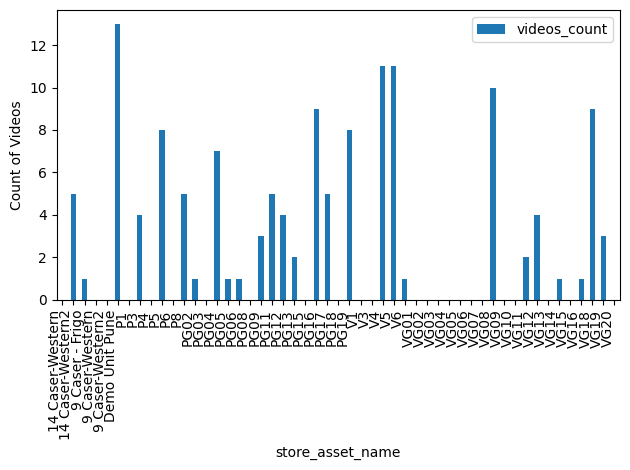

In [24]:
frame = video_manager.frame.copy()
f = frame.reset_index()
f['date'] = f.date.apply(lambda x: x.date())
f.set_index('date', inplace=True)
f[f.index == pd.to_datetime('2024-07-18').date()]
today = pd.Timestamp('today').date()  # Get today's date as a date object
todays_data = f[(f.index == today) & (f['video_status'] == 'top3Clear')]
todays_videos_count = todays_data.groupby('store_asset_name').size()
all_stores = pd.Series(index=pd.Index(frame['store_asset_name'].unique(), name='store_asset_name'), dtype=int)
todays_videos_count = all_stores.combine_first(todays_videos_count).fillna(0).astype(int)
todays_videos_count_df = todays_videos_count.reset_index(name='videos_count')
ax = todays_videos_count_df.plot(kind='bar', x='store_asset_name', y='videos_count', legend=False)
ax.set_ylabel('Count of Videos')
plt.xticks(rotation=90, ha='right')
plt.tight_layout()
plt.show()

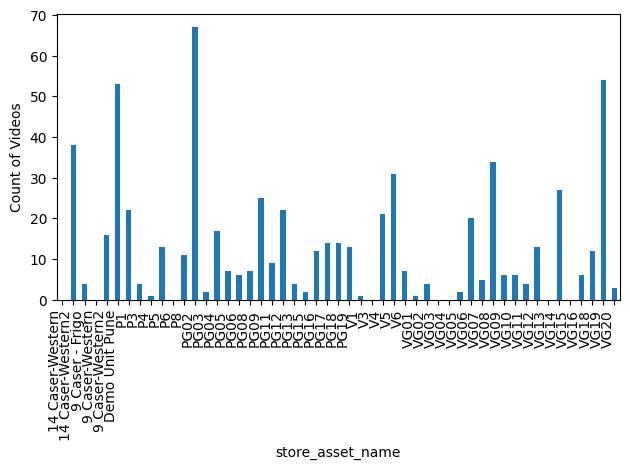

In [28]:
frame = video_manager.frame.copy()
f = frame.reset_index()
f = f[f.video_status != 'closedDoor']
f['date'] = f.date.apply(lambda x: x.date())
f.set_index('date', inplace=True)
f[f.index == pd.to_datetime('2024-07-18').date()]
today = pd.Timestamp('today').date()  # Get today's date as a date object
todays_data = f[(f.index == today) & (f['video_status'] != 'closedDoor')]
todays_videos_count = todays_data.groupby('store_asset_name').size()
all_stores = pd.Series(index=pd.Index(frame['store_asset_name'].unique(), name='store_asset_name'), dtype=int)
todays_videos_count = all_stores.combine_first(todays_videos_count).fillna(0).astype(int)
todays_videos_count_df = todays_videos_count.reset_index(name='videos_count')
ax = todays_videos_count_df.plot(kind='bar', x='store_asset_name', y='videos_count', legend=False)
ax.set_ylabel('Count of Videos')
plt.xticks(rotation=90, ha='right')
plt.tight_layout()
plt.show()

<Figure size 1200x600 with 0 Axes>

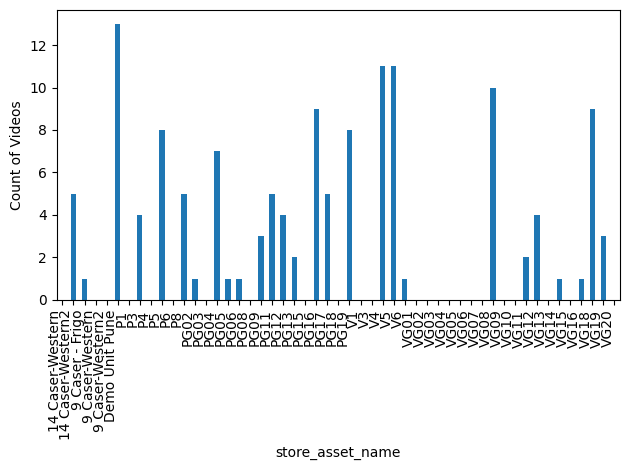

In [31]:
import pandas as pd
import matplotlib.pyplot as plt

frame = video_manager.frame.copy()
f = frame.reset_index()
f['date'] = f['date'].apply(lambda x: x.date())  # Strip time part from datetime
f.set_index('date', inplace=True)

# Filter for today's data with status 'top3Clear'
today = pd.Timestamp('today').date()  # Get today's date as a date object
todays_data = f[(f.index == today) & (f['video_status'] == 'top3Clear')]

# Count videos per store
todays_videos_count = todays_data.groupby('store_asset_name').size()

# Ensure all stores are represented
all_stores = pd.Series(index=pd.Index(frame['store_asset_name'].unique(), name='store_asset_name'), dtype=int)
todays_videos_count = all_stores.combine_first(todays_videos_count).fillna(0).astype(int)

# Plotting
todays_videos_count_df = todays_videos_count.reset_index(name='videos_count')
plt.figure(figsize=(12, 6))
ax = todays_videos_count_df.plot(kind='bar', x='store_asset_name', y='videos_count', legend=False)
ax.set_ylabel('Count of Videos')
plt.xticks(rotation=90, ha='right')
plt.tight_layout()
plt.show()

In [33]:
todays_data

file  ...        mac_id
date                                                           ...              
2024-07-19  /media/akshay/datasets/coke/siteData/08B61F98D...  ...  08B61F98D888
2024-07-19  /media/akshay/datasets/coke/siteData/EC64C9A71...  ...  EC64C9A711F4
2024-07-19  /media/akshay/datasets/coke/siteData/08B61F99B...  ...  08B61F99BA30
2024-07-19  /media/akshay/datasets/coke/siteData/08B61F99B...  ...  08B61F99BA30
2024-07-19  /media/akshay/datasets/coke/siteData/08B61F98F...  ...  08B61F98F224
...                                                       ...  ...           ...
2024-07-19  /media/akshay/datasets/coke/siteData/FCE8C0A79...  ...  FCE8C0A79254
2024-07-19  /media/akshay/datasets/coke/siteData/08B61F99A...  ...  08B61F99AF90
2024-07-19  /media/akshay/datasets/coke/siteData/FCE8C0A79...  ...  FCE8C0A79254
2024-07-19  /media/akshay/datasets/coke/siteData/FCE8C0CD8...  ...  FCE8C0CD8A9C
2024-07-19  /media/akshay/datasets/coke/siteData/FCE8C0CDC...  ...  FCE8C0CDC2AC

[135 rows x 7 columns]

<Figure size 1200x600 with 0 Axes>

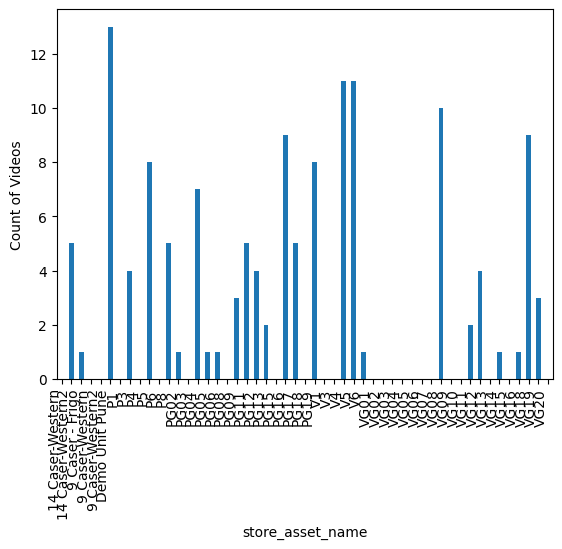

# Downloader

In [1]:
from pathlib import Path
from fabric import Connection
from tqdm.auto import tqdm
import re
import pandas as pd
import traceback
from loguru import logger
from argparse import ArgumentParser
from multiprocessing import Pool

/home/akshay/.virtualenvs/detectron2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
remote_dir = "/tmp/akshay/test"
local_dir = Path("/tmp/testDownload/downloadTesting")
if not local_dir.is_dir():
    local_dir.mkdir()
d = DirDownloader(remote_dir, local_dir)

In [4]:
d.download()

/datdisk/sdc/script/ai_analytics/chillerinference/data/uploads: 2 files found



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.44it/s]


['/tmp/akshay/test',
 '/tmp/akshay/test2',
 '/tmp/akshay/test3',
 '/tmp/akshay/test4']

In [1]:
from pathlib import Path
from fabric import Connection
from tqdm.auto import tqdm
import re
import pandas as pd
import traceback
from loguru import logger
from argparse import ArgumentParser
from multiprocessing import Pool
from multiprocessing import Pool
from functools import partial
from shelfSettings import STORE_MAPPER
import time
from pathlib import Path

/home/akshay/.virtualenvs/detectron2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-07-21 07:30:05.067 | INFO     | shelfSettings:__init__:115 - Initializing StoreManager with raise_exception: True
2024-07-21 07:30:05.072 | INFO     | shelfSettings:__init__:120 - Loaded store: Demo Unit Pune: 08B61F99AF90: DemoUnit
2024-07-21 07:30:05.072 | INFO     | shelfSettings:__init__:120 - Loaded store: 9 Caser - Frigo: 08F9E0F662D8: Madhuban Rasoi
2024-07-21 07:30:05.072 | INFO     | shelfSettings:__init__:120 - Loaded store: 14 Caser-Western: 08B61F99B440: Rajal Dryfruits
2024-07-21 07:30:05.073 | INFO     | shelfSettings:__init__:120 - Loaded store: 14 Caser-Western2: C82E18224378: Rajal Dryfruits2
2024-07-21 07:30:05.073 | INFO     | shelfSettings:__init__:120 - Loaded store: 9 Caser-Western: 08F9E0ECCC

In [2]:
class DirDownloader:
    def __init__(self, remote_dir, local_dir):
        self.remote_dir = remote_dir
        self.local_dir = local_dir
        self.connection = self._get_connection()
    
    def download(self):
        files = self._get_files_for_dir(self.remote_dir)
        total = len(files)
        local_paths = [self.get_local_path(f) for f in files]
        actual = [Path(f) for f in local_paths if not Path(f).is_file()]
        logger.info(f"{self.remote_dir} --> {self.local_dir}: [{len(actual)}/{len(files)}] to download")
        time.sleep(4)
        return
        for remote_file, local_file in tqdm(zip(files, local_paths)):
            status = self.download_file(file, local_file)

    def _get_connection(self):
        connection = Connection(
                    host='iot',
                    user='azureuser',
                    connect_kwargs={
                        "key_filename": "/home/akshay/.ssh/iot.pem",
                    }
                )        
        return connection
    def _get_files_for_dir(self, remote_dir):
        get_files_command = f"find {remote_dir} -name '*.jpg'"
        files_result = self.connection.run(get_files_command, hide="stdout")
        # files_result = self.connection.run(get_files_command)
        if files_result.ok:
            files = files_result.stdout.split("\n")
            files = [f for f in files if len(f) > 0]
            return files
        return []

    def get_local_path(self, remote_path):
        local_path = re.sub(self.remote_dir, str(self.local_dir), remote_path)
        return local_path

    def download_file(self, remote_path, local_path):
        # local_path = self.get_local_path(remote_path)
        # local_path = Path(local_path)
        if local_path.is_file():
            # logger.debug(f"file already exists: {local_path}")
            return True
        if not local_path.parent.is_dir():
            local_path.parent.mkdir(parents=True)

        try:
            # logger.debug(f"downloading: {remote_path}")
            res = self.connection.get(remote_path, str(local_path))
            if not res:
                logger.error(f"unable to download: {remote_path}")                
                return False            
            return True
        except Exception as e:
            logger.error(e)
            trace_string = traceback.format_exc()
            logger.error(trace_string)
            return False


def download(remote_dir, base_local_dir):
    # local_dir = Path("/tmp/testDownload/downloadTesting") / Path(remote_dir).name
    try:
        d = DirDownloader(remote_dir, base_local_dir / Path(remote_dir).name)
        d.download()
    except Exception as e:
        logger.error(e)
        trace_string = traceback.format_exc()
        logger.error(trace_string)

In [3]:
class SFTPDownloader:
    def __init__(self, server_dir=None, local_dir=None, num_threads=4):
        self.connection = self.connect()
        self.num_threads = num_threads
        
        if server_dir is None:
            self.SERVER_DIR = "/datdisk/sdc/rdp/cocacola"
        else:
            self.SERVER_DIR = server_dir

        if local_dir is None: 
            if Path("/home/akshay/datasets").is_dir():       
                self.LOCAL_DIR = Path('/home/akshay/siteData')
            else:
                self.LOCAL_DIR = Path('/media/akshay/datasets/coke/siteData')
        else:
            self.LOCAL_DIR = Path(local_dir)
        if not self.LOCAL_DIR.is_dir():
            self.LOCAL_DIR.mkdir()    

        self.asset_name_mapping = {s.mac_id.lower(): s.asset_name for s in STORE_MAPPER.store_mappings}
        self.name_mapping = {s.mac_id.lower(): s.name for s in STORE_MAPPER.store_mappings}
        self.MACS = [s.mac_id.lower() for s in STORE_MAPPER.store_mappings if s.asset_name[0] in ['V', 'P']]
    def connect(self):
        return Connection(
                    host='iot',
                    user='azureuser',
                    connect_kwargs={
                        "key_filename": "/home/akshay/.ssh/iot.pem",
                    }
                )        

    def get_site_dirs(self):
        # command = f"find {SERVER_DIR}/00B0D063C226 -name '*.avi'"
        command = f"find {self.SERVER_DIR} -maxdepth 1 -type d"
        result = self.connection.run(command, hide='stdout')
        if result.ok:
            remote_dirs = result.stdout.split("\n")[1:]
            remote_dirs = [r for r in remote_dirs if len(r) > 0 and self.is_valid(r)]
            logger.info(f"Found [{len(remote_dirs)}] remote dirs")
        return remote_dirs

    def get_mac_id(self, path):
        p = str(path)
        if self.SERVER_DIR[-1] != "/":
            server_dir = self.SERVER_DIR + "/"
        else:
            server_dir = self.SERVER_DIR 
        sub_path = p.split(server_dir)[-1]
        mac = sub_path.split("/")[0].lower()
        return mac

    def is_valid(self, path):
        mac = self.get_mac_id(path)
        # print(f"{mac}, result: {mac in MACS}")
        if mac in self.MACS:
            return True
        return False

    def get_local_path(self, remote_path):
        local_path = re.sub(self.SERVER_DIR, str(self.LOCAL_DIR), remote_path)
        return local_path
    
    def display_local_summary(self):
        sub_dirs = [d for d in self.LOCAL_DIR.iterdir() if d.is_dir()]
        for sub_dir in sorted(sub_dirs, key=lambda x: self.asset_name_mapping.get(x.name.lower(), x.name)):
            files = list(sub_dir.glob('**/*.avi'))
            if sub_dir.name.lower() in self.asset_name_mapping:
                asset_name = self.asset_name_mapping[sub_dir.name.lower()]
            else:
                asset_name = sub_dir.name
            retailer_name = self.name_mapping.get(sub_dir.name.lower(), "")
            logger.info(f"{asset_name:12s}: {retailer_name:40s}: {len(files)}")

    def sync(self):
        remote_dirs = self.get_site_dirs()
        download_fn = partial(download, base_local_dir=self.LOCAL_DIR)
        with Pool(self.num_threads) as pool:
            r = pool.imap(download_fn, remote_dirs)
            results = [result for result in r] 
        # self.display_local_summary()

    def _get_files_for_dir(self, remote_dir):
        get_files_command = f"find {remote_dir} -name '*.avi'"
        files_result = self.connection.run(get_files_command, hide="stdout")
        # files_result = self.connection.run(get_files_command)
        if files_result.ok:
            files = files_result.stdout.split("\n")
            files = [f for f in files if len(f) > 0 and self.is_valid(f)]
            return files
        return []


In [4]:
csv_path = Path("/home/akshay/workspace/computervision/cokeInference/data/shopConfig.csv")
sftp_downloader = SFTPDownloader()

In [ ]:
sftp_downloader.sync()

2024-07-21 07:30:10.199 | INFO     | __main__:get_site_dirs:40 - Found [45] remote dirs
2024-07-21 07:30:12.695 | INFO     | __main__:download:12 - /datdisk/sdc/rdp/cocacola/FCE8C0CE262C -- /media/akshay/datasets/coke/siteData/FCE8C0CE262C: [4568/4568] to download
2024-07-21 07:30:13.144 | INFO     | __main__:download:12 - /datdisk/sdc/rdp/cocacola/FCE8C0CDCEC0 -- /media/akshay/datasets/coke/siteData/FCE8C0CDCEC0: [5212/5212] to download
2024-07-21 07:30:13.756 | INFO     | __main__:download:12 - /datdisk/sdc/rdp/cocacola/FCE8C0A77870 -- /media/akshay/datasets/coke/siteData/FCE8C0A77870: [8199/8199] to download
2024-07-21 07:30:14.040 | INFO     | __main__:download:12 - /datdisk/sdc/rdp/cocacola/08B61F98D888 -- /media/akshay/datasets/coke/siteData/08B61F98D888: [11021/11021] to download
2024-07-21 07:30:19.896 | INFO     | __main__:download:12 - /datdisk/sdc/rdp/cocacola/08B61F98F224 -- /media/akshay/datasets/coke/siteData/08B61F98F224: [6330/6330] to download
2024-07-21 07:30:20.340 |

In [12]:
import pandas as pd
from pathlib import Path
import re
from analyzeVideos import VideoManager

In [9]:
frame_path = Path("/media/akshay/datasets/coke/siteData/videoStats.parquet")
frame = pd.read_parquet(frame_path)

In [13]:
video_manager = VideoManager()
frame = video_manager.frame

2024-07-21 12:27:14.275 | INFO     | analyzeVideos:load_frame:40 - Loading video analysis frame: /media/akshay/datasets/coke/siteData/videoStats.parquet records: 92222 last modified: 2024-07-21 11:31:02.632431


In [18]:
frame.iloc[0].file

'/media/akshay/datasets/coke/siteData/08F9E0F662D8/19700101/08F9E0F662D8_1234_377.avi'

In [21]:
frame[frame.file == "/media/akshay/datasets/coke/siteData/08F9E0F662D8/19700101/08F9E0F662D8_1234_377.avi"].iloc[0]

file                /media/akshay/datasets/coke/siteData/08F9E0F66...
category            [glareOrFog, glareOrFog, glareOrFog, glareOrFo...
confidence          [0.9932618737220764, 0.9524450302124023, 0.985...
video_status                                               glareOrFog
store_name                                             Madhuban Rasoi
store_asset_name                                      9 Caser - Frigo
mac_id                                                   08F9E0F662D8
Name: 1970-01-01 05:30:01, dtype: object

In [15]:
query_file_name = "C82E18224378_1721360869585_4938.avi"
if query_file_name:
    query_frame = frame[frame.file.str.contains(query_file_name, flags=re.IGNORECASE)]
    if query_frame.empty:
        print("No data found for the query")
    else:
        print(query_frame)

                                                                  file  \
date                                                                     
2024-07-19 09:17:49  /media/akshay/datasets/coke/siteData/C82E18224...   

                                                              category  \
date                                                                     
2024-07-19 09:17:49  [closedDoor, closedDoor, closedDoor, notOpenEn...   

                                                            confidence  \
date                                                                     
2024-07-19 09:17:49  [0.999984860420227, 0.9999934434890747, 0.9581...   

                            video_status        store_name   store_asset_name  \
date                                                                            
2024-07-19 09:17:49  openButNotTop3Clear  Rajal Dryfruits2  14 Caser-Western2   

                           mac_id  
date                               
2024-07-19 09:1